In [2]:
%env NGS_DIR=/mnt/scratch/NGS
%env CTX=user_u:object_r:user_tmp_t:s0

%env NICKNAME=gind.alex
%env READ_ID=SRR10720402
%env CHR_ID=5


import os
basedir = f"{os.environ['NGS_DIR']}/{os.environ['NICKNAME']}"

env: NGS_DIR=/mnt/scratch/NGS
env: CTX=user_u:object_r:user_tmp_t:s0
env: NICKNAME=gind.alex
env: READ_ID=SRR10720402
env: CHR_ID=5


## Работа на kodomo 
> В папке `/mnt/scratch/NGS` создайте директорию, которая будет называться, как ваш логин на kodomo. Используйте команду mkdir.

In [3]:
!!mkdir --context="$CTX" -p "$NGS_DIR/$NICKNAME/hisat" "$NGS_DIR/$NICKNAME/dna_reads" "$NGS_DIR/$NICKNAME/hg38"

[]

# Подготовка референса 

## Получение референса
> Подготовка референса Создайте папку для последовательности генома и индекса к программе для картирования с помощью hisat2, скопируйте в нее файл с вашей хромосомой. Теперь это ваш референс.

In [5]:
%%bash
cp --context="$CTX" "$NGS_DIR/DATA/hg38/Homo_sapiens.GRCh38.dna.chromosome.$CHR_ID.fa" "$NGS_DIR/$NICKNAME/hg38/chr38.$CHR_ID.fa"
cp --context="$CTX" "$NGS_DIR/DATA/dna_reads/${READ_ID}_1.fastq.gz" "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}_1.fastq.gz"
cp --context="$CTX" "$NGS_DIR/DATA/dna_reads/${READ_ID}_2.fastq.gz" "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}_2.fastq.gz"

## Индексация для hisat2
через `-p` укажем использовать 25 потоков.

параметр `-q` убирает ненужные логи.

последним аргументом положим индексные файлы в директорию для hisat

In [171]:
!!hisat2-build -p 25 -q "$NGS_DIR/$NICKNAME/hg38/chr38.$CHR_ID.fa" "$NGS_DIR/$NICKNAME/hisat/index"

[]

>(должно получиться 8 файлов .ht2)

In [10]:
%%bash
ls $NGS_DIR/$NICKNAME/hisat/index*

/mnt/scratch/NGS/gind.alex/hisat/index.1.ht2
/mnt/scratch/NGS/gind.alex/hisat/index.2.ht2
/mnt/scratch/NGS/gind.alex/hisat/index.3.ht2
/mnt/scratch/NGS/gind.alex/hisat/index.4.ht2
/mnt/scratch/NGS/gind.alex/hisat/index.5.ht2
/mnt/scratch/NGS/gind.alex/hisat/index.6.ht2
/mnt/scratch/NGS/gind.alex/hisat/index.7.ht2
/mnt/scratch/NGS/gind.alex/hisat/index.8.ht2


## Индексация samtools
>Из полученного chrN.fa.fai узнайте точное имя своей хромосомы и длину вашей
хромосомы в нуклеотидах.

>(*) Объясните каждую цифру из файла, полученного после индексирования референса с
помощью samtools.

для этого выведем индекс `fai` cat'ом, заменим tsv на маркдаун для отображения. из [мануала faidx](https://manpages.ubuntu.com/manpages/bionic/man5/faidx.5.html) 
берем названия столбцов и ставим их в хедер таблицы md.

название референсной последовательности - первый столбец (сохраним его так же в переменную для будущих задач)

In [12]:
from IPython import display


samtool_index = !samtools faidx "$NGS_DIR/$NICKNAME/hg38/chr38.$CHR_ID.fa" && cat "$NGS_DIR/$NICKNAME/hg38/chr38.$CHR_ID.fa.fai"
chr_name = samtool_index[0][:samtool_index[0].find('\t')]
%env CHR_NAME=$chr_name
samtool_index_table = '|name|length|offset|linebases|linewidth|\n|---|---|---|---|---|\n|' + samtool_index[0].replace('\t', '|') + '|'
display.display_markdown(samtool_index_table, raw=True)

env: CHR_NAME=5


|name|length|offset|linebases|linewidth|
|---|---|---|---|---|
|5|181538259|56|60|61|

1. столбец длины показывает кол-во оснований в последовательности, т.е.
```bash
$ tail -n +2 <reads> | tr -d "\n" | wc -c
<length>
```
2. столбец `offset` длину шапки в байтах (строки с >), т.е.
```python
open(<reads>, 'rb').read()[:<offset>] == open(<reads>, 'rb').readlines()[0]
```
3. столбец `linebases` показывает кол-во оснований на каждой строке, т.е.
```bash
$ head -2 <reads> | tail -1 | tr -d "\n" | wc -c
<linebases>
```
4. столбец `linewidth` такой же, как и linebases, но в байтах, т.е.
```bash
$ head -2 <reads> | tail -1 | wc -c
<linewidth>
```

# Чтения ДНК

## Описание образца

## Проверка качества исходных чтений 
> Проанализируйте качество исходных чтений с помощью программы fastqc, исследуйте оба (!!!) файла 

параметром `-q` уберем логи

In [34]:
!!fastqc -q "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}_1.fastq.gz"

[]

In [35]:
!!fastqc -q "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}_2.fastq.gz"

[]

чтобы посмотреть на отчеты fastqc встроим их html в наш отчет 

In [25]:
import lxml.html as lxml_html
from IPython import display

dna_reads_dir = f"{basedir}/dna_reads"
dna_read_filename_prefix = f"{dna_reads_dir}/{os.environ['READ_ID']}"
def display_fastqc_report(filename):
    fastqc_doc = display.HTML(filename=filename)
    
    # возьмем только основную часть, чтобы стили из отчета fastqc не мешали нашему отчету
    fastqc_report = lxml_html.document_fromstring(fastqc_doc.__html__()).xpath("//div[contains(@class, 'main')]")[0]
    
    # установим позиционирование, так как оно не дружит по умолчанию
    fastqc_report.set('style', 'display:block;position:relative;top:0;bottom:0;left:0;right:0;')
    
    display.display_html(lxml_html.tostring(fastqc_report).decode('utf-8'), raw=True)

Basic Statistics Measure Value Filename SRR10720402_1.fastq.gz File type Conventional base calls Encoding Sanger / Illumina 1.9 Total Sequences 28966798 Sequences flagged as poor quality 0 Sequence length 75 %GC 43 Per base sequence quality Per tile sequence quality Per sequence quality scores Per base sequence content Per sequence GC content Per base N content Sequence Length Distribution Sequence Duplication Levels Overrepresented sequences No overrepresented sequences Adapter Content
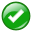
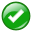
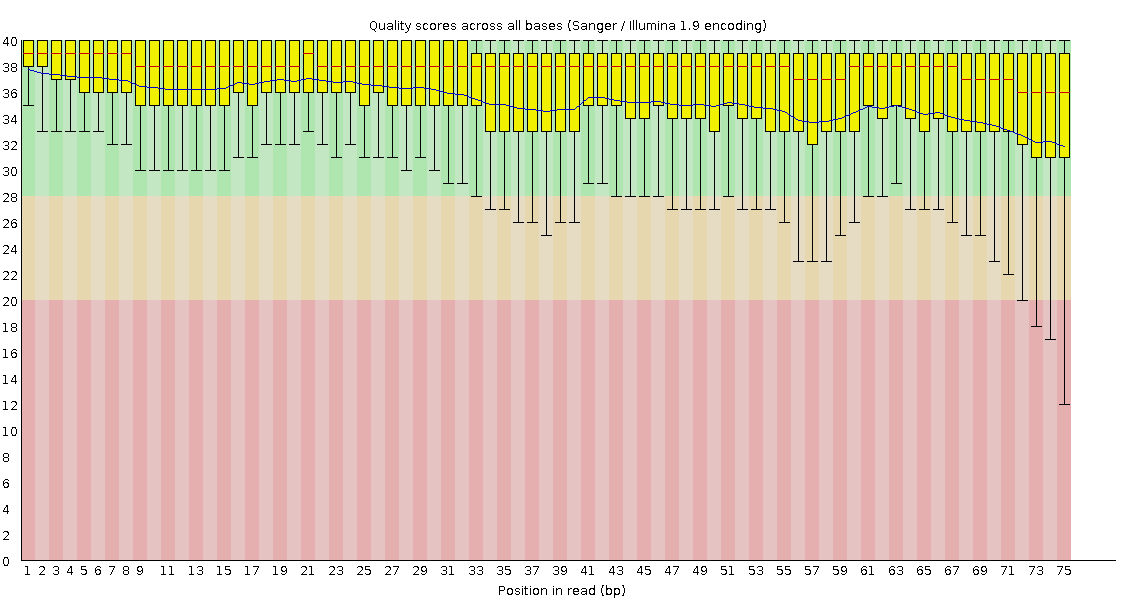
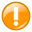
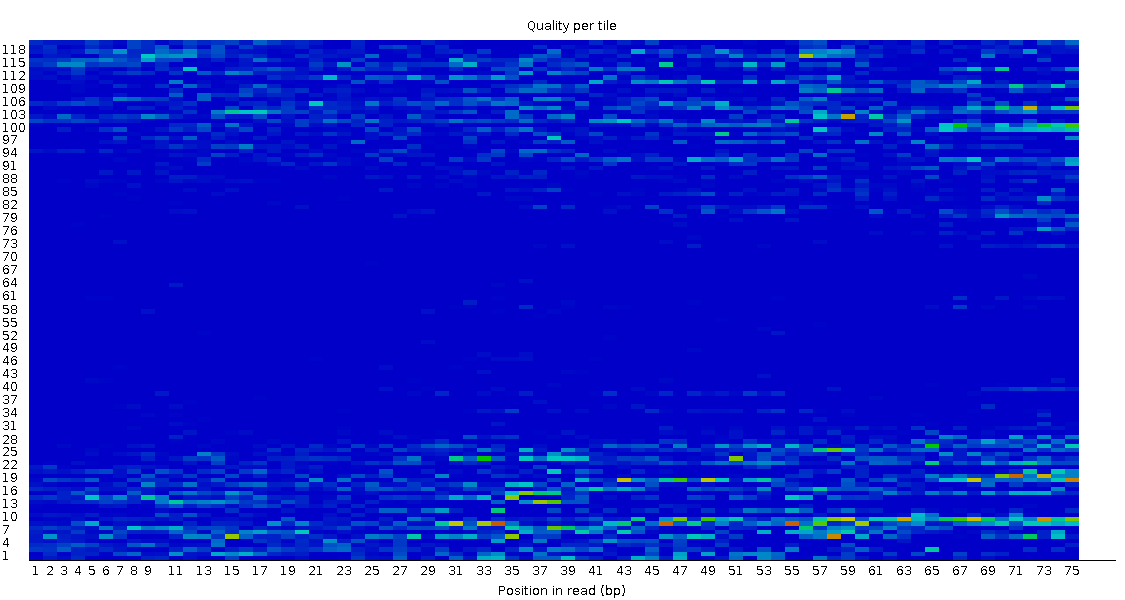
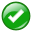
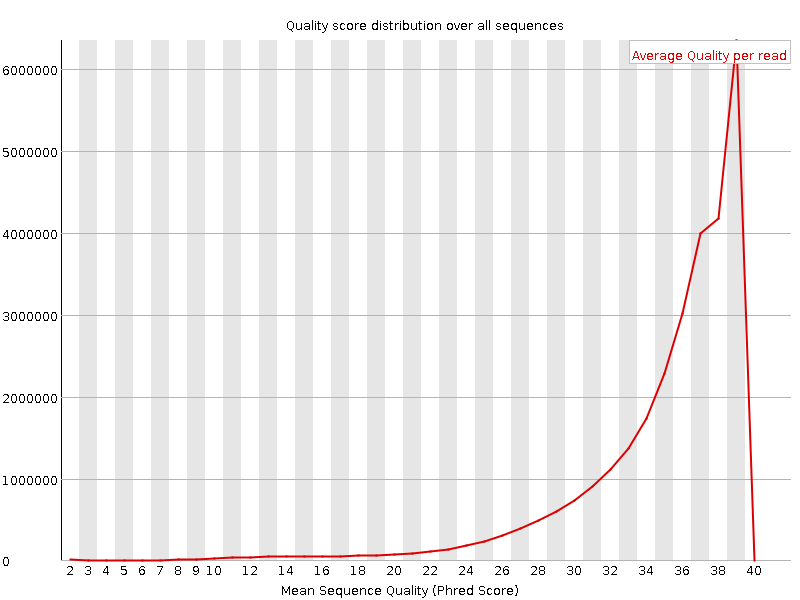
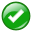
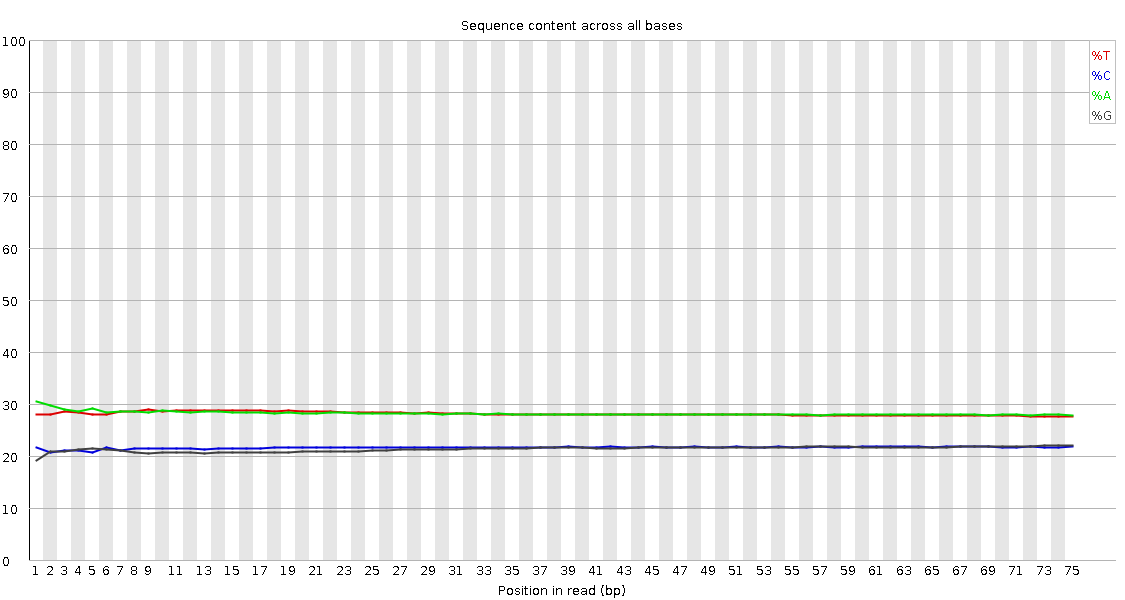
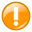
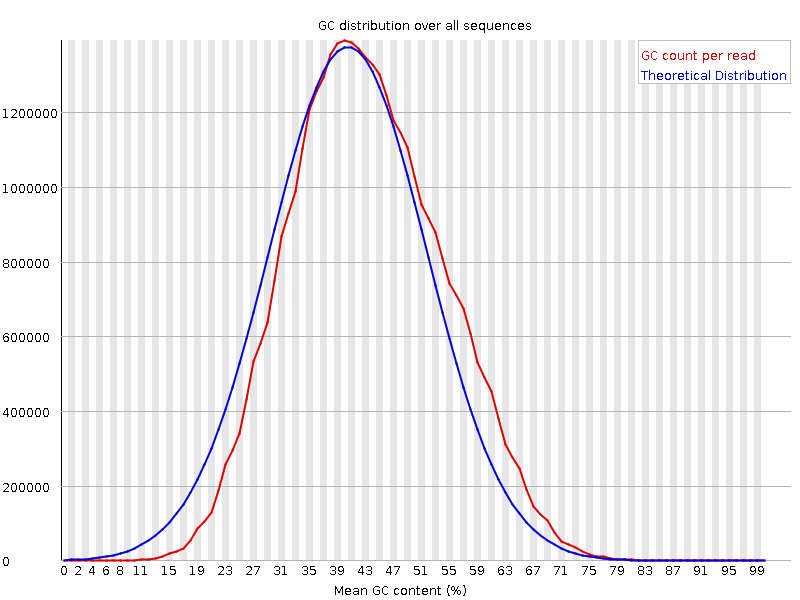
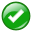
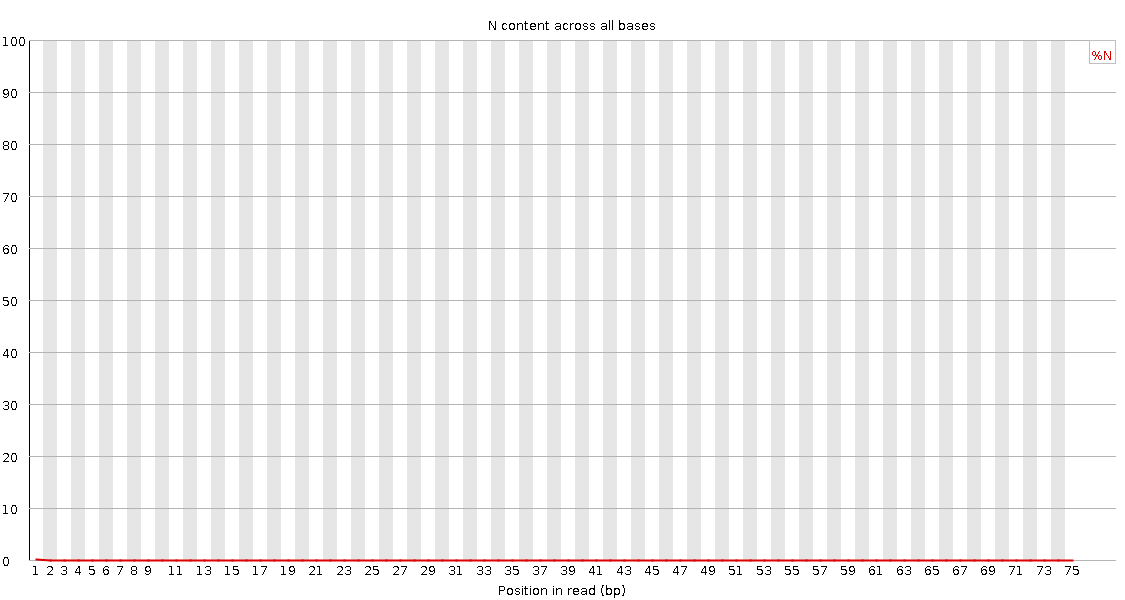
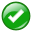
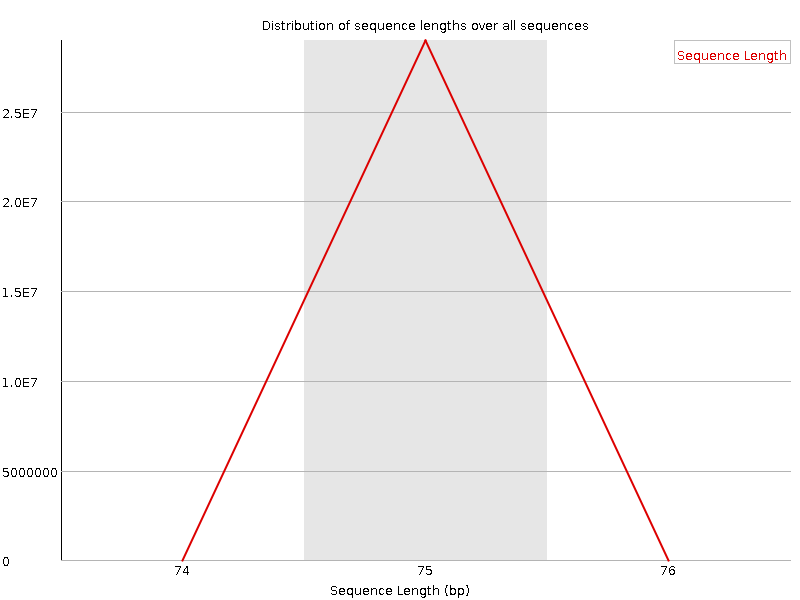
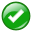
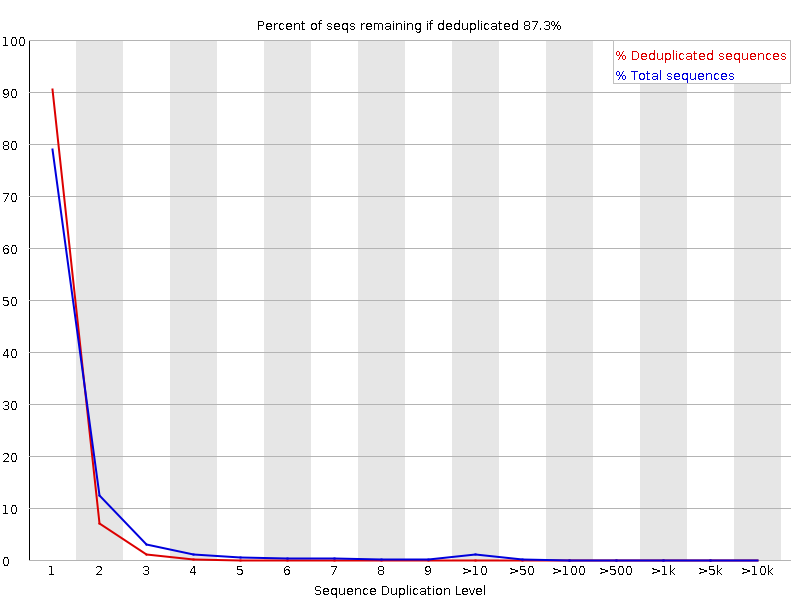
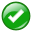
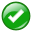
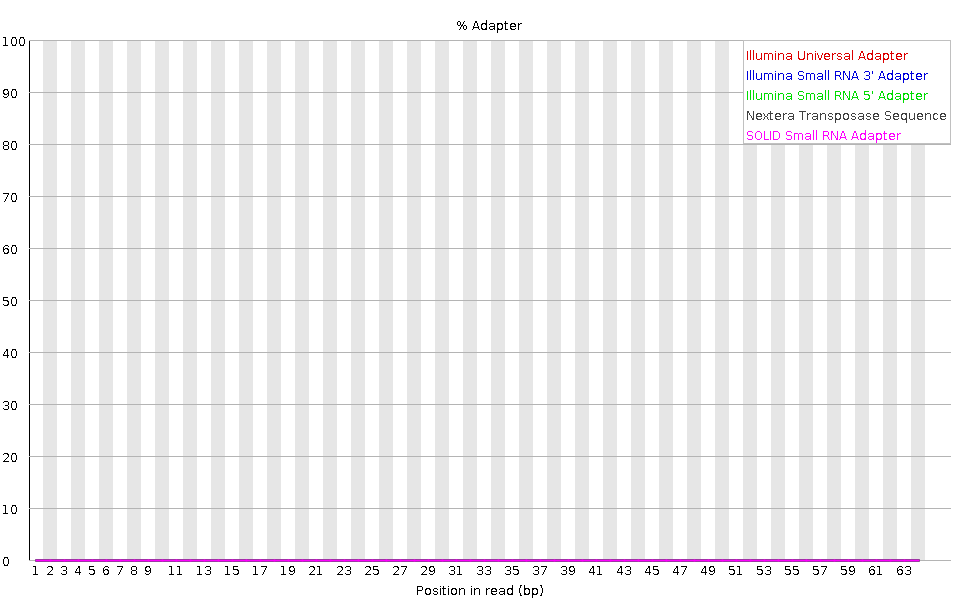

In [26]:
display_fastqc_report(dna_read_filename_prefix + '_1_fastqc.html')

#### Чтения прямые

1. >какое количество пар чтений получилось

в таблице `Basic Statistics` в строке `Total Sequences` указано кол-во: `28966798`

2. >краткий комментарий качества пар чтений

только крайние перцентили единичных позиций выходят из зеленой зоны оценки качества.
все остальное (медиана, средняя, тело свечей) лежит возле врехнего края графика у большинства позиций, что показывает высокое качество чтений. 

3. >краткий комментарий о длине ваших чтений

последовательностей длины 74 и 76 найдено 0 => все чтения длиной 75

4. >краткий комментарий о любых других результатах fastqc.

`Per tile sequence quality` показывает отклонения в качестве от среднего по позициям камеры секвенатора. на нем видно,
что некоторые позиции с низкокачественными чтениями, но отклонения слабые и их мало, что подтверждает приемлимую оценку качества чтений.
`Per sequence quality scores` показывает график средних качеств по каждому чтению. на нем видно,
что бОльшая сосредоточена в высоких оценках, быстро убывая, что подтверждает приемлимое качество чтений.
`Per base sequence content` показывает проценты оснований по чтениям, на котором мы видим,
что процент остается +- стабильным среди всех чтений, а так же, что A/T немного превалируют над G/C.
`Per sequence GC content` показывает процент GC по чтениям и его сравнение с теоритическим распределением.
наши чтения немного сдвинуты относительно модели, но несильно, что показывает приемлимое качество чтений.
`Per base N content` показывает нераспознанные основания по чтениям. на нашем графике видно, что их нету.
`Sequence Duplication Levels` показывает распределение дупликатов в наших чтениях.
всего уникальных чтений, судя по графику, 87.3% из всех чтений уникальные.
так же видно, что бОльшая часть повторов, это чтения по 2, 3 и немного по 10 раз

Basic Statistics Measure Value Filename SRR10720402_2.fastq.gz File type Conventional base calls Encoding Sanger / Illumina 1.9 Total Sequences 28966798 Sequences flagged as poor quality 0 Sequence length 75 %GC 44 Per base sequence quality Per tile sequence quality Per sequence quality scores Per base sequence content Per sequence GC content Per base N content Sequence Length Distribution Sequence Duplication Levels Overrepresented sequences No overrepresented sequences Adapter Content
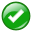
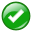
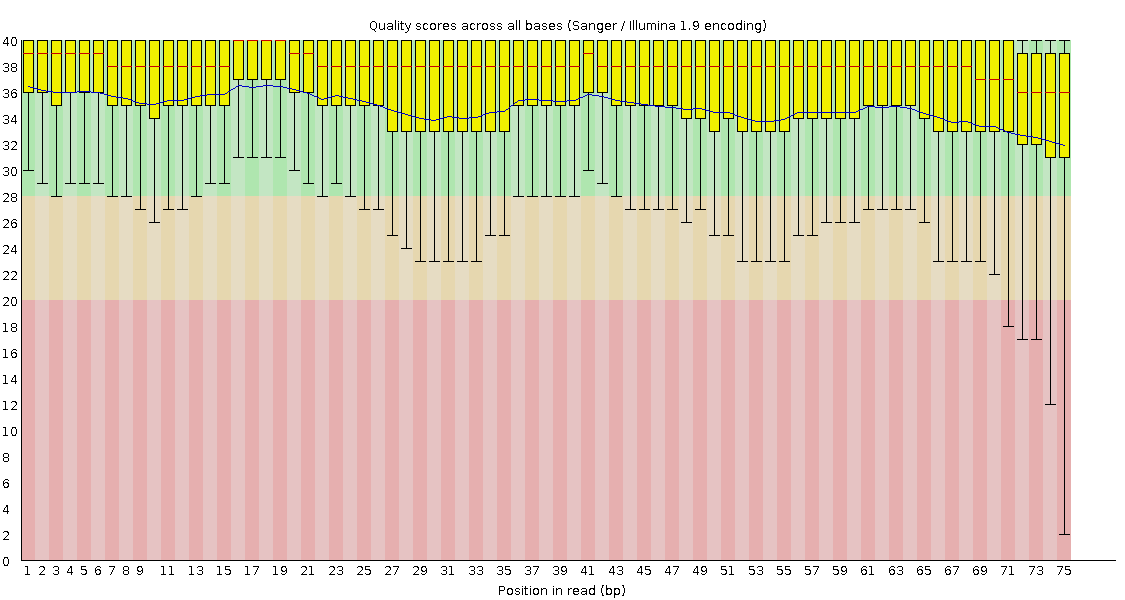
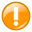
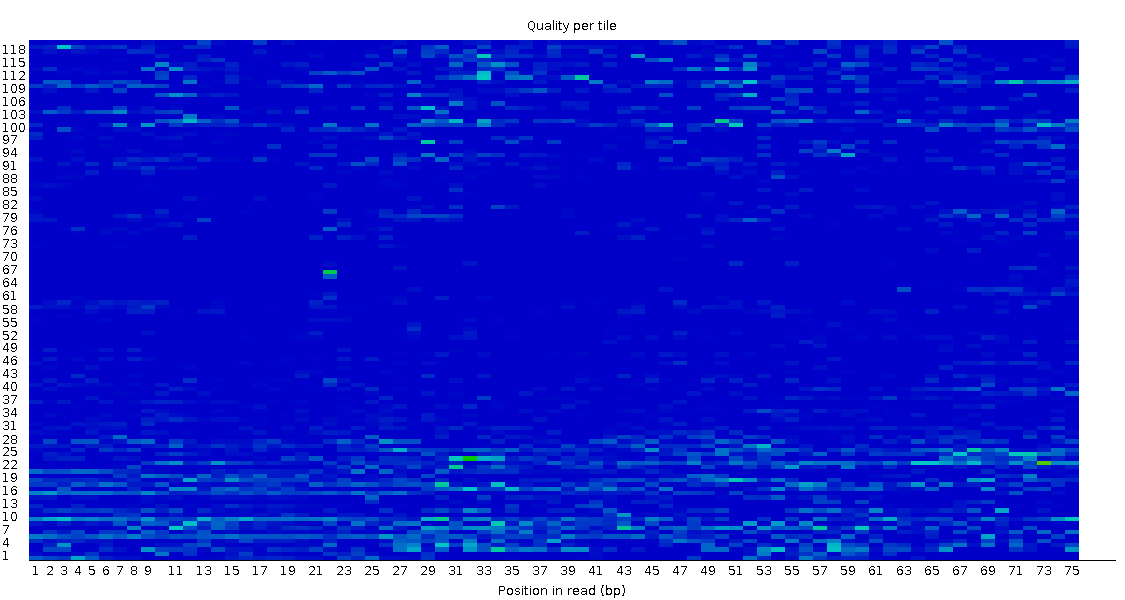
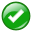
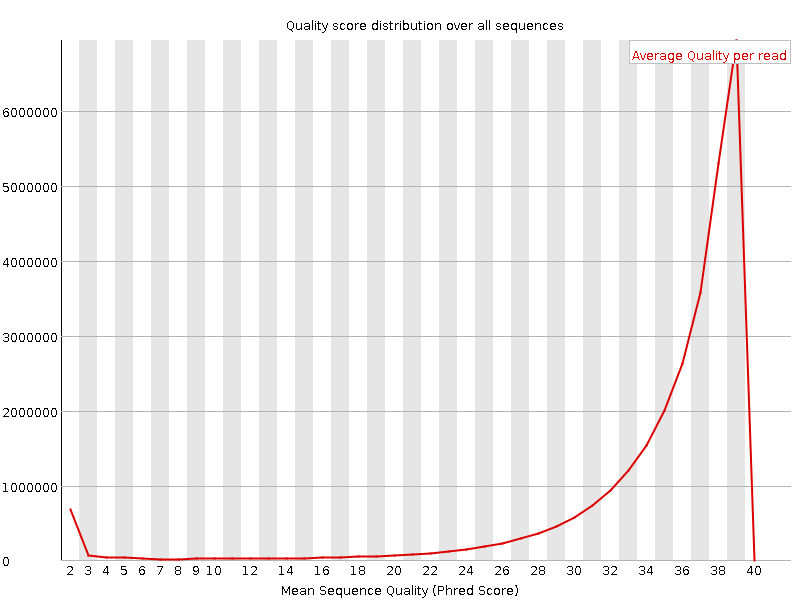
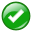
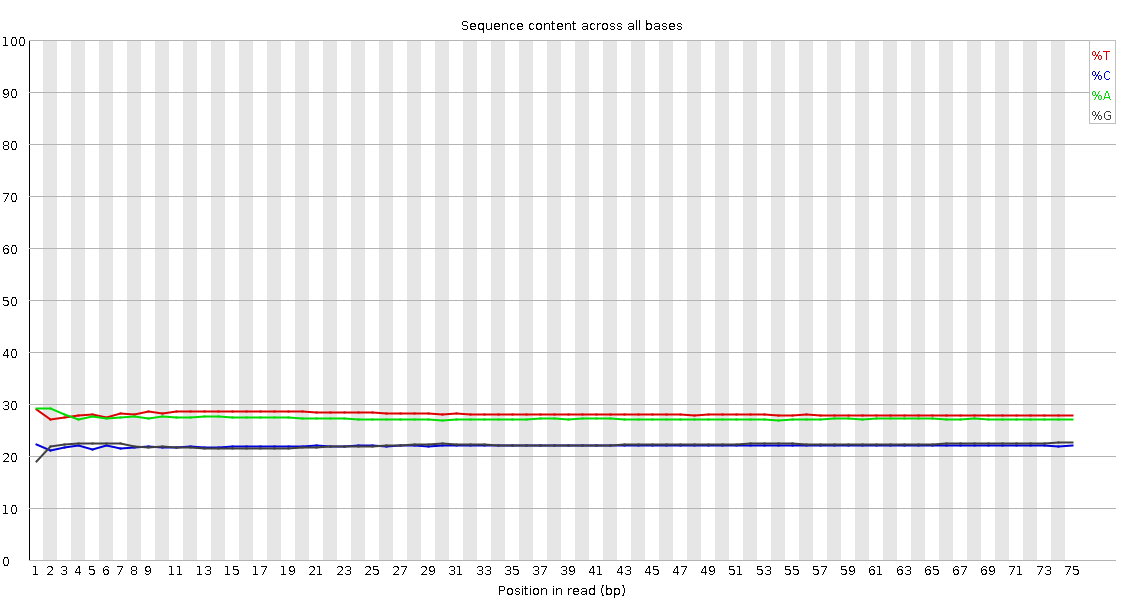
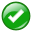
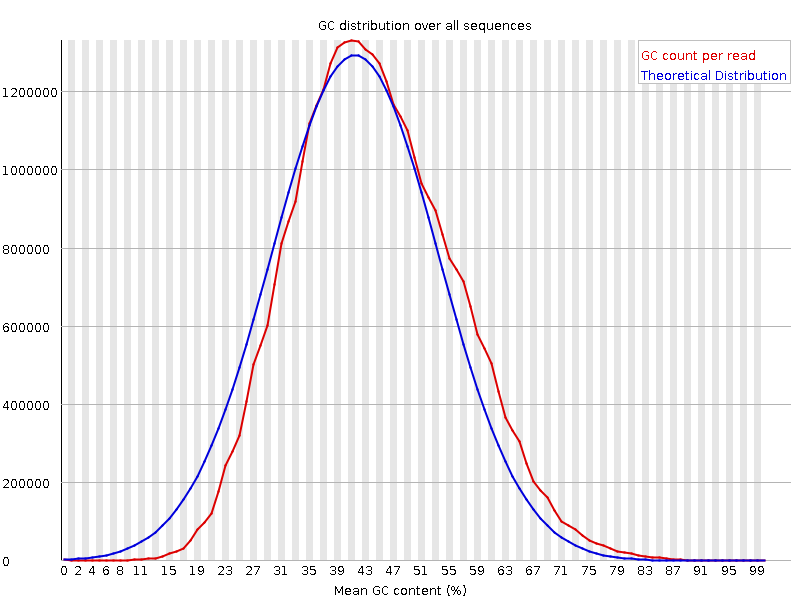
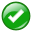
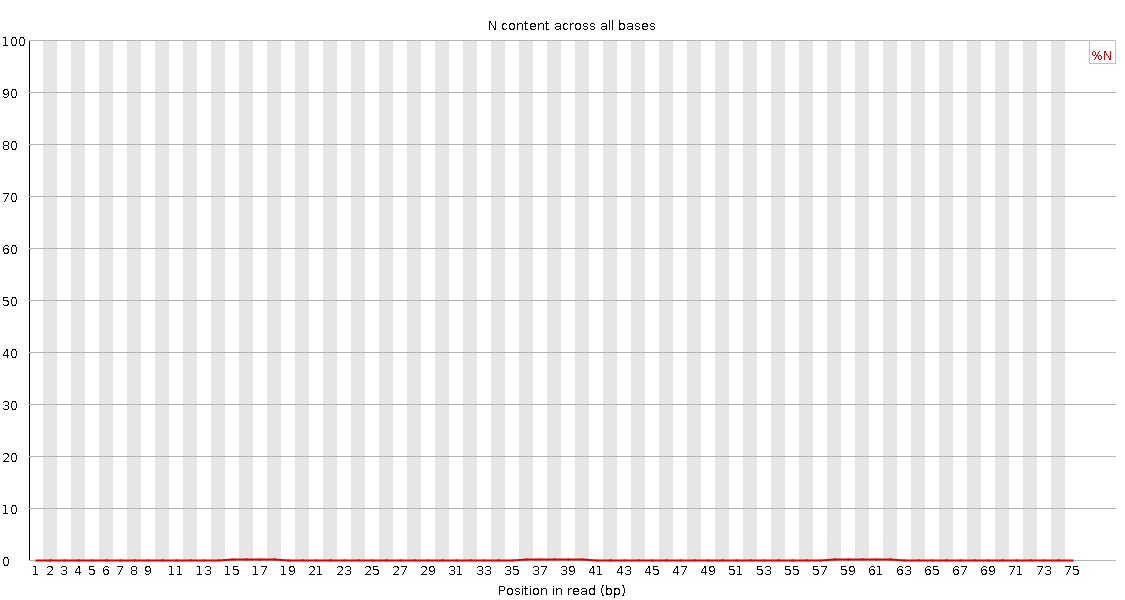
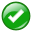
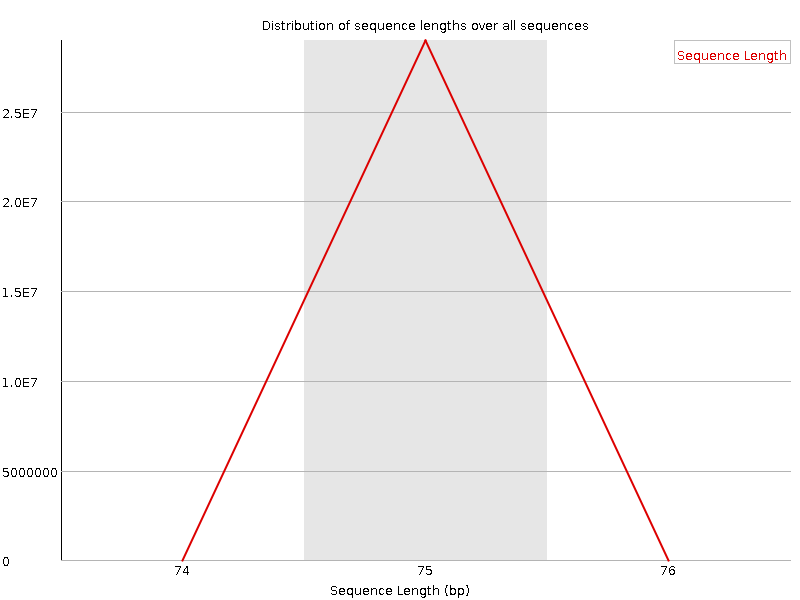
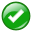
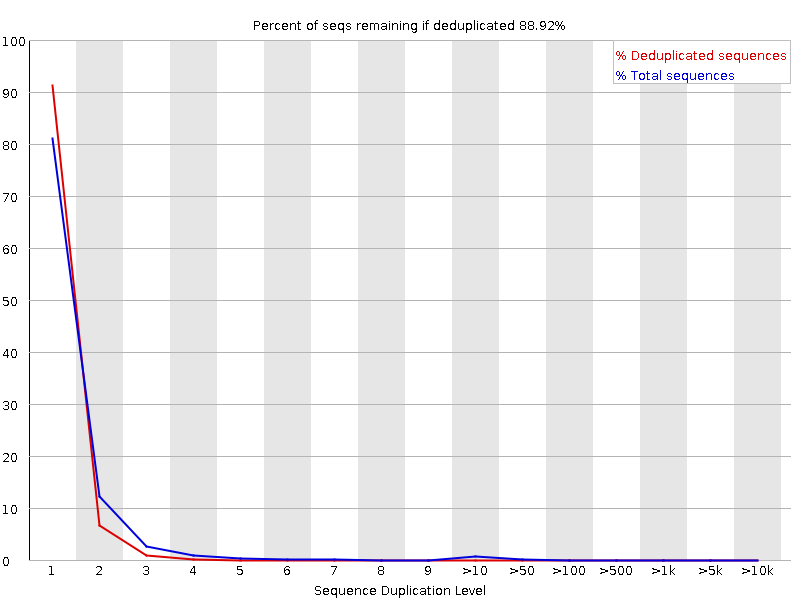
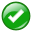
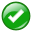
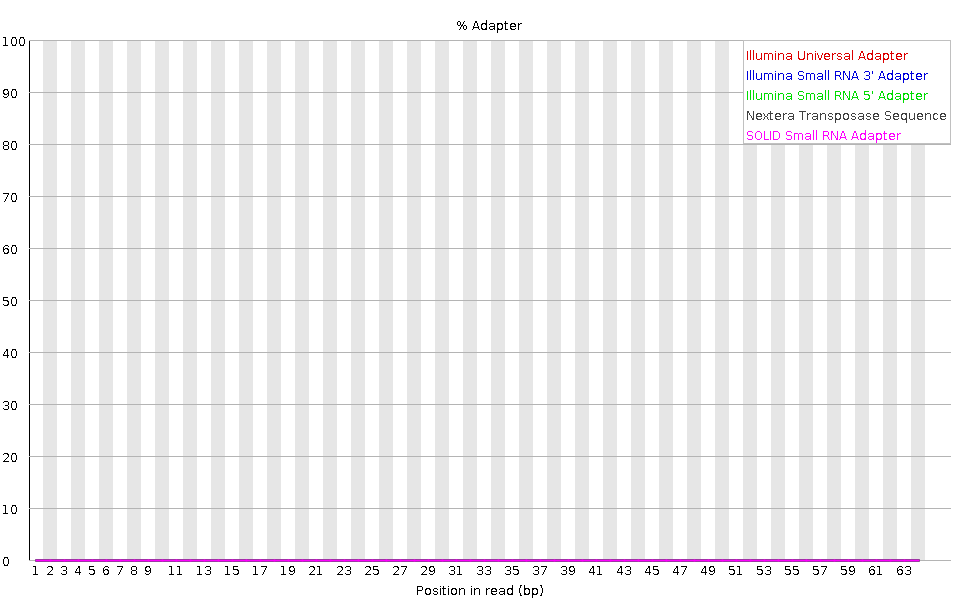

In [54]:
display_fastqc_report(dna_read_filename_prefix + '_2_fastqc.html')

#### Чтения обратные

1. >какое количество пар чтений получилось

в таблице `Basic Statistics` в строке `Total Sequences` указано кол-во: `28966798`

>совпадает ли количество чтений у “прямых” чтений и “обратных” чтений

совпадает кол-во чтений прямых и обратных

2. >краткий комментарий качества пар чтений

только крайние перцентили единичных позиций выходят из зеленой зоны оценки качества.
все остальное (медиана, средняя, тело свечей) лежит возле врехнего края графика у большинства позиций.
несколько крайних перцентилей хуже, чем у прямых, но общее качество остается хорошим

3. >краткий комментарий о длине ваших чтений

последовательностей длины 74 и 76 найдено 0 => все чтения длиной 75

4. >краткий комментарий о любых других результатах fastqc.

`Per tile sequence quality` показывает похожее распределение качества по tile'ам, как у прямых чтений.
на `Per sequence quality scores` видно чуть больше, чем у прямых, чтений с плохой средней,
но общее качество остается хорошим.
на `Per base sequence content` видно, что процент чуть менее стабилен от основания к основания,
чем у прямых, но ничего критического.
`Per sequence GC content` показывает так же небольшой сдвиг от модели.
`Sequence Duplication Levels` показывает распределение дупликатов в наших чтениях.
всего уникальных чтений, судя по графику, 88.9% из всех чтений уникальные, что больше,
чем у прямых. а так же количество чтений, прочтенных 10 раз, меньше, чем у прямых. 

## Фильтрация чтений 

>Вне зависимости от качества исходных чтений, проведите их фильтрацию с помощью trimmomatic.

`TrimmomaticPE` используется, чтобы за раз обработать парные чтения.
параметр `-phred33` указывает используемый при секвенировании pipeline.
второй параметр указывает путь до прямых чтений, вслед за ним указывается путь до обратных.
дальше указываются пути, по которым нужнно сгенерировать отчеты:
1. прямые парные
2. прямые непарные
3. обратные парные
4. обратные непарные

>Удалите с КОНЦА чтений нуклеотиды с качеством ниже 20 (без прохода окном!)

для этого используется фильтр `TRAILING` со значением `20`.

>оставьте только такие чтения, длина которых не ниже 50 нуклеотидов

для этого используется фильтр `MINLEN` со значением `50`.

>Подумайте о том, почему после работы trimmomatic получается именно 4 файла и что содержится в каждом из них.

согласно [мануалу](http://www.usadellab.org/cms/uploads/supplementary/Trimmomatic/TrimmomaticManual_V0.32.pdf)
1. `forward paired` содержит прямые чтения, в которых и прямые и обратные прошли фильтры
2. `forward unpaired` содержит прямые чтения, в которых только прямые прошли фильтры
3. `reverse paired` содержит обратные чтения, в которых и прямые и обратные прошли фильтры
4. `reverse unpaired` содержит обратные чтения, в которых только обратные прошли фильтры

In [50]:
%%bash

TrimmomaticPE \
    -phred33 \
    "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}_1.fastq.gz" \
    "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}_2.fastq.gz" \
    "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.1.forward.paired.fastq.gz" \
    "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.1.forward.unpaired.fastq.gz" \
    "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.2.reverse.paired.fastq.gz" \
    "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.2.reverse.unpaired.fastq.gz" \
    TRAILING:20 MINLEN:50

TrimmomaticPE: Started with arguments:
 -phred33 /mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402_1.fastq.gz /mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402_2.fastq.gz /mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402.1.forward.paired.fastq.gz /mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402.1.forward.unpaired.fastq.gz /mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402.2.reverse.paired.fastq.gz /mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402.2.reverse.unpaired.fastq.gz TRAILING:20 MINLEN:50
Multiple cores found: Using 4 threads
Input Read Pairs: 28966798 Both Surviving: 27172718 (93.81%) Forward Only Surviving: 1197393 (4.13%) Reverse Only Surviving: 473184 (1.63%) Dropped: 123503 (0.43%)
TrimmomaticPE: Completed successfully


## Проверка качества триммированных чтений

сначала построим отчеты по всем чтениям

In [55]:
!!fastqc -q "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.1.forward.paired.fastq.gz"

[]

In [56]:
!!fastqc -q "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.1.forward.unpaired.fastq.gz"

[]

In [57]:
!!fastqc -q "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.2.reverse.paired.fastq.gz"

[]

In [58]:
!!fastqc -q "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.2.reverse.unpaired.fastq.gz"

[]

затем посмотрим отчеты

Basic Statistics Measure Value Filename SRR10720402.1.forward.paired.fastq.gz File type Conventional base calls Encoding Sanger / Illumina 1.9 Total Sequences 27172718 Sequences flagged as poor quality 0 Sequence length 50-75 %GC 43 Per base sequence quality Per tile sequence quality Per sequence quality scores Per base sequence content Per sequence GC content Per base N content Sequence Length Distribution Sequence Duplication Levels Overrepresented sequences No overrepresented sequences Adapter Content
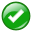
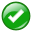
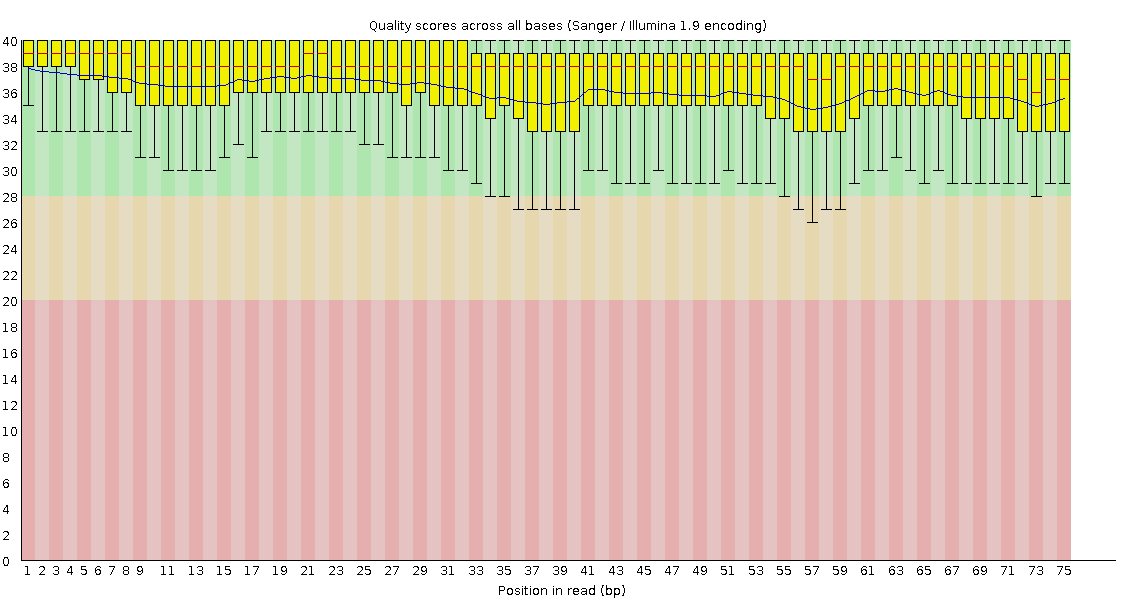
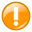
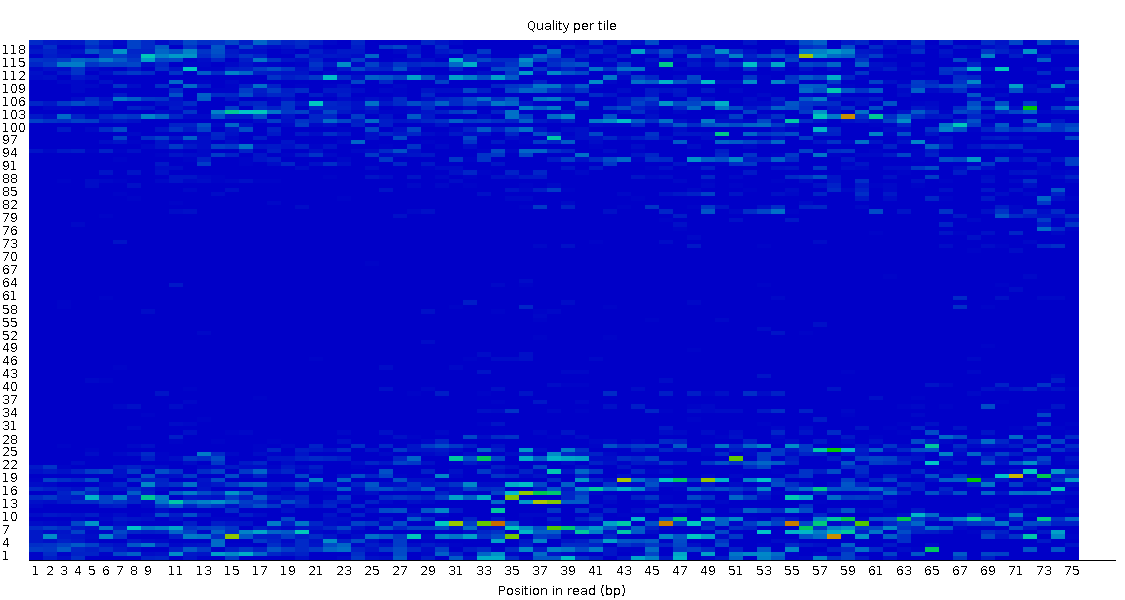
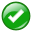
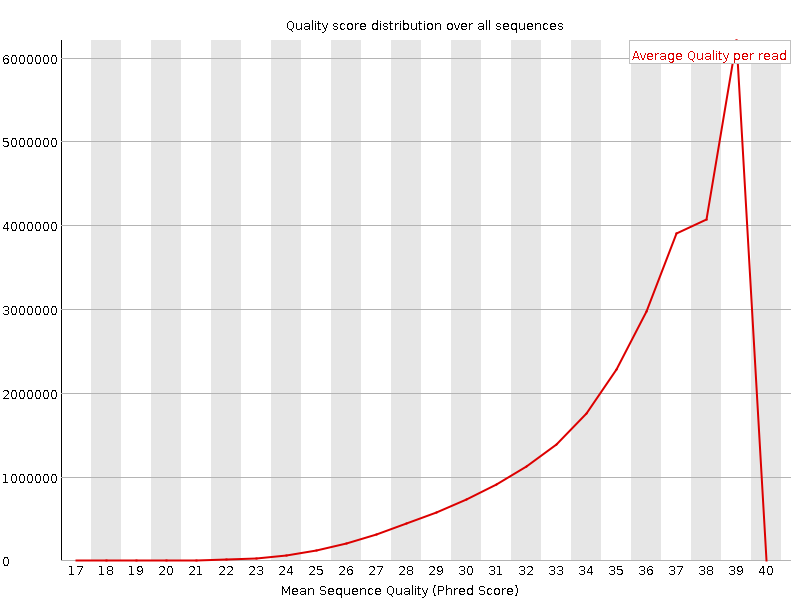
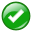
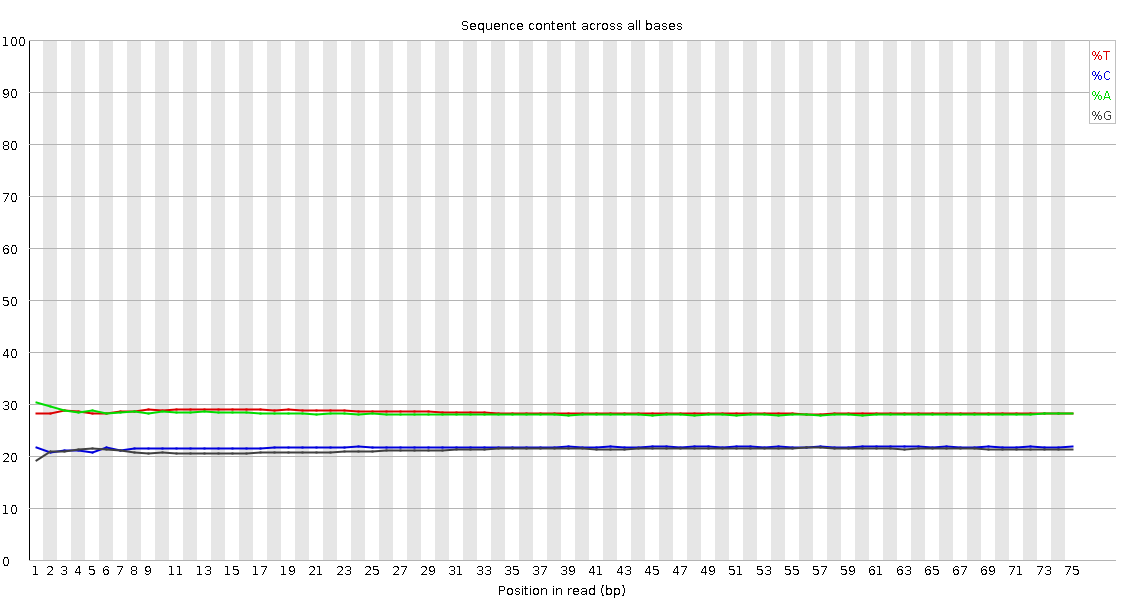
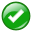
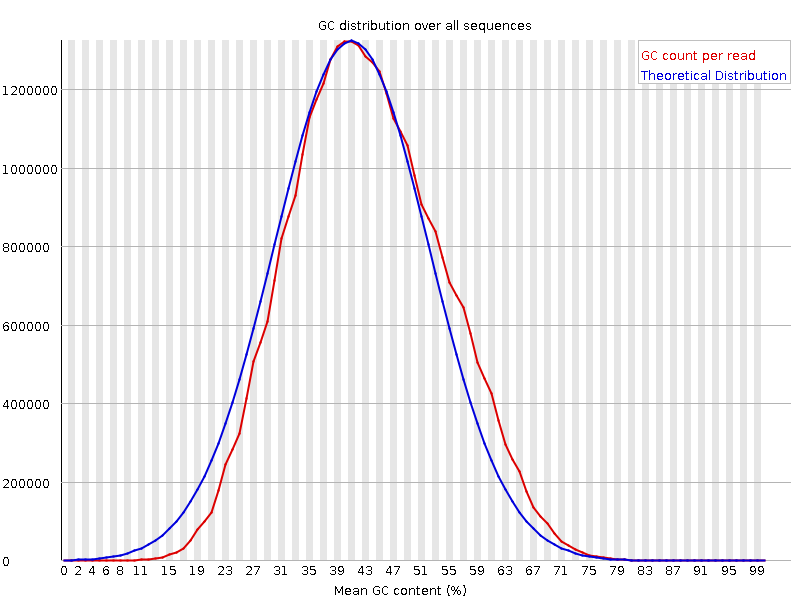
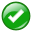
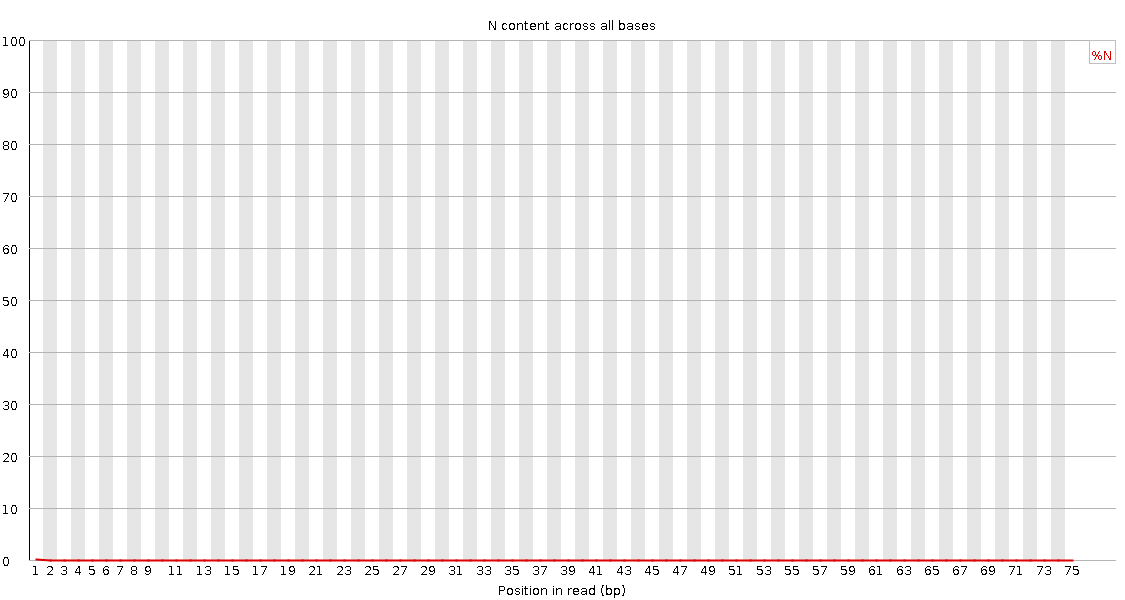
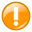
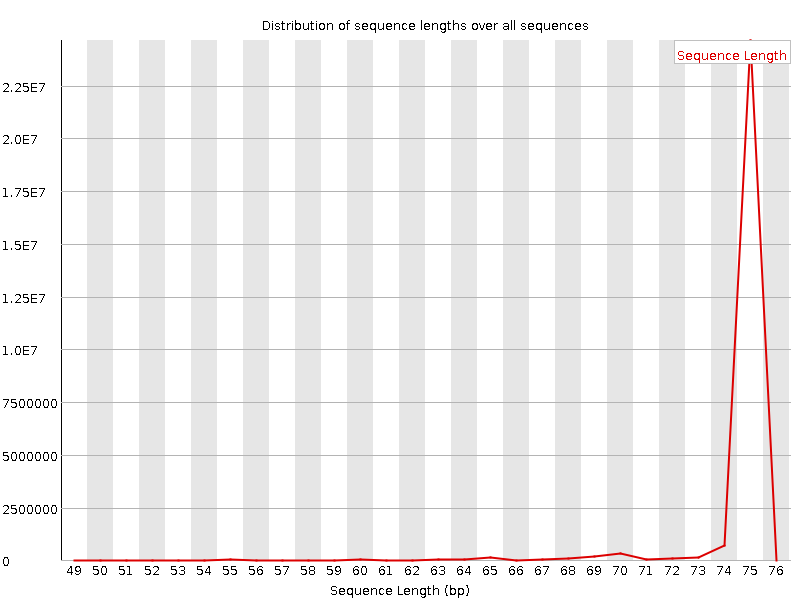
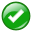
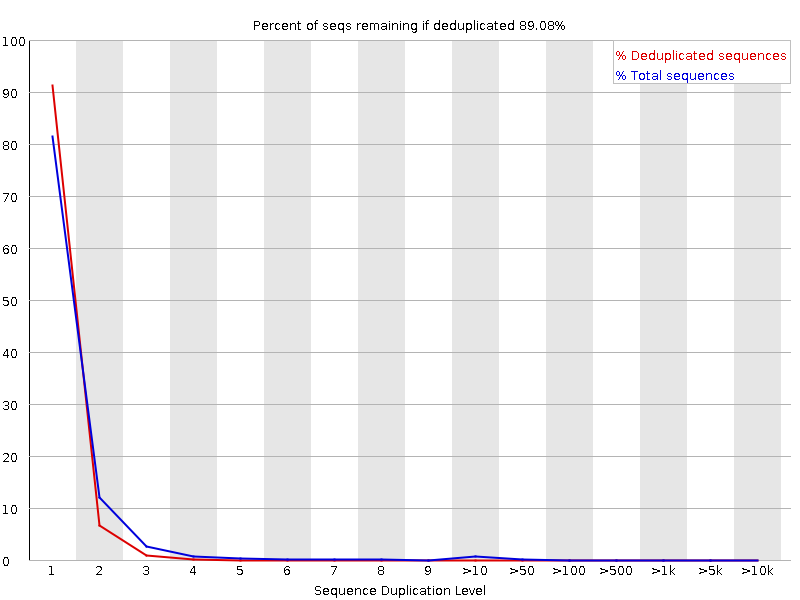
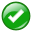
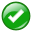
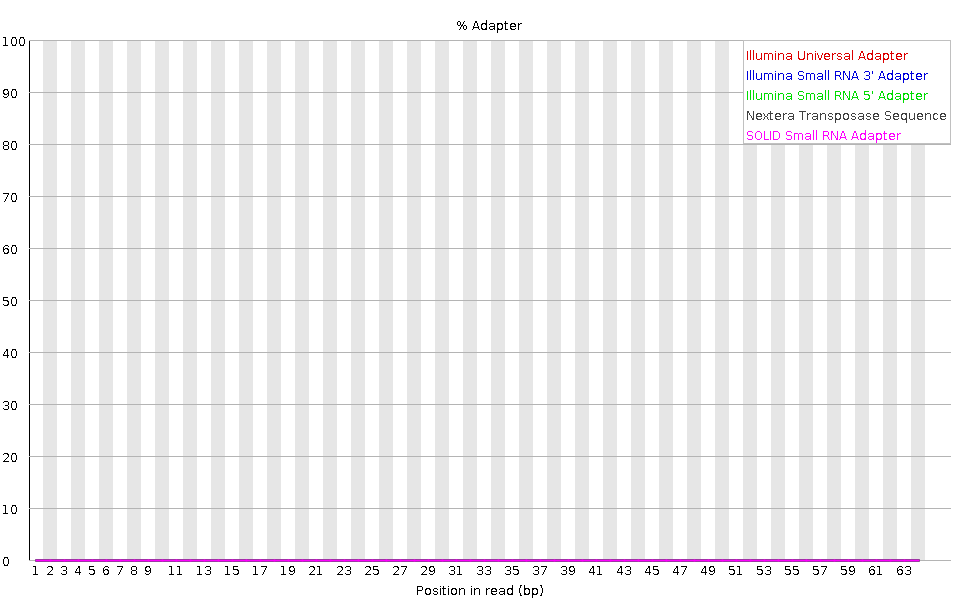

In [59]:
display_fastqc_report(dna_read_filename_prefix + '.1.forward.paired_fastqc.html')

Basic Statistics Measure Value Filename SRR10720402.1.forward.unpaired.fastq.gz File type Conventional base calls Encoding Sanger / Illumina 1.9 Total Sequences 1197393 Sequences flagged as poor quality 0 Sequence length 50-75 %GC 41 Per base sequence quality Per tile sequence quality Per sequence quality scores Per base sequence content Per sequence GC content Per base N content Sequence Length Distribution Sequence Duplication Levels Overrepresented sequences No overrepresented sequences Adapter Content
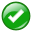
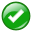
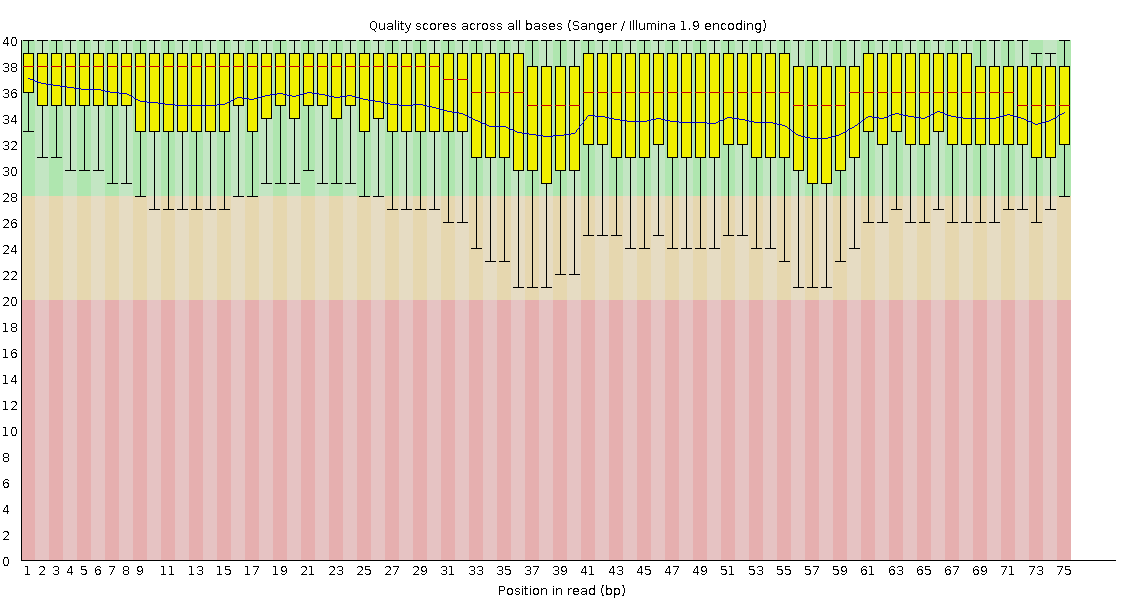
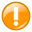
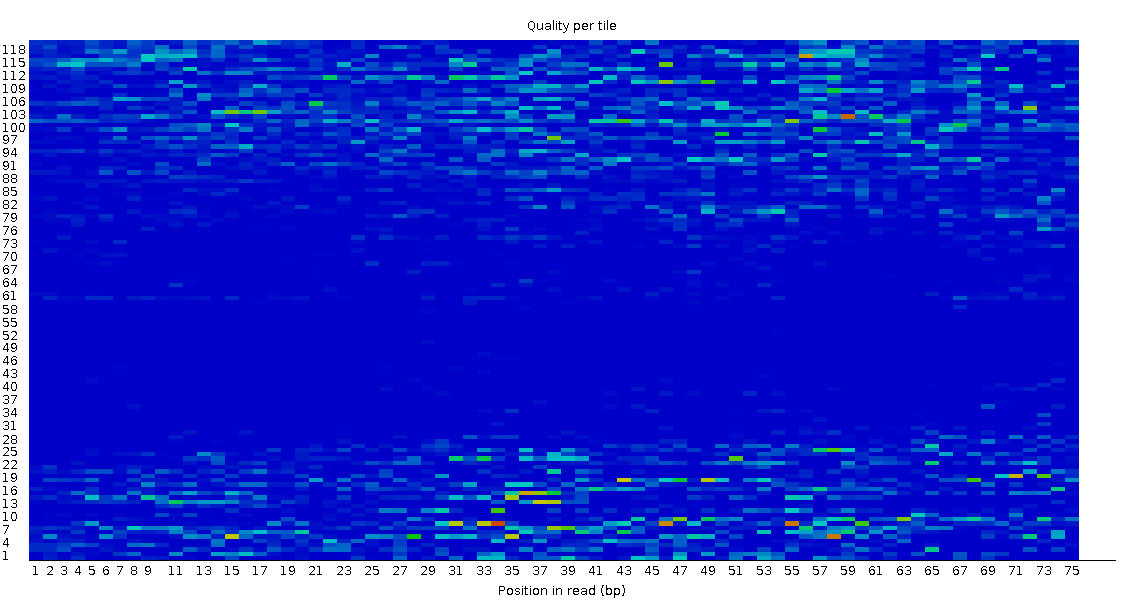
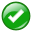
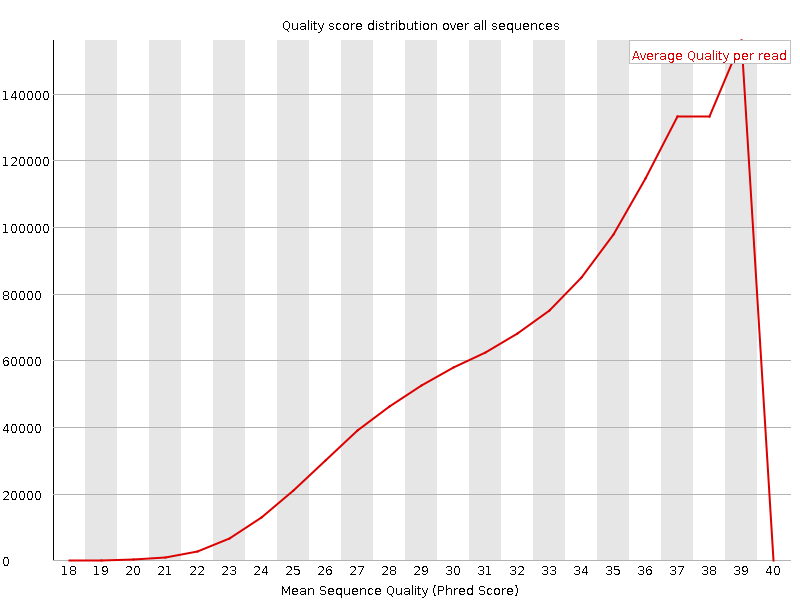
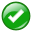
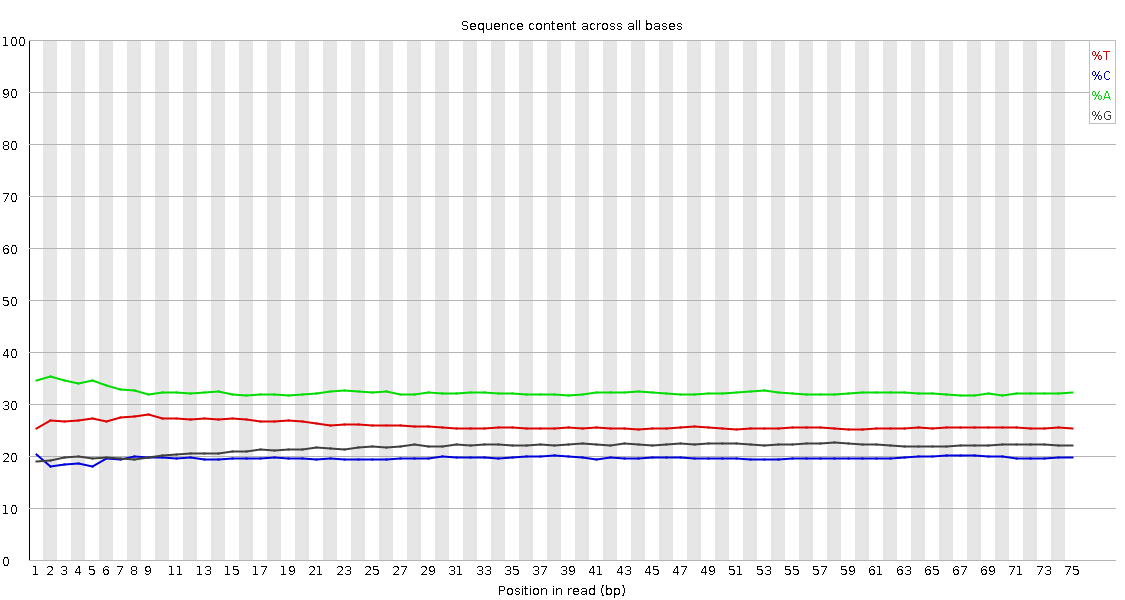
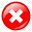
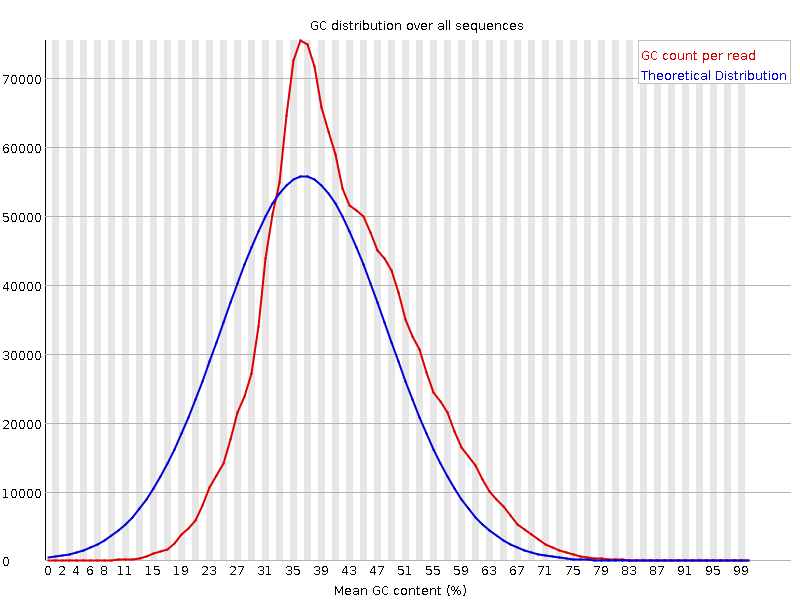
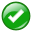
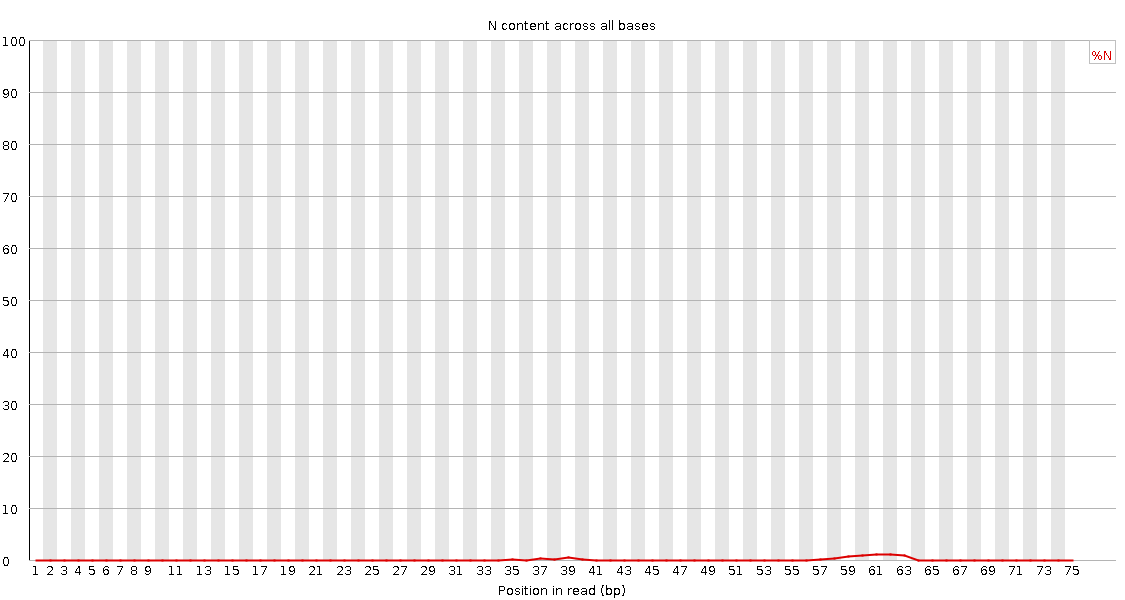
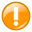
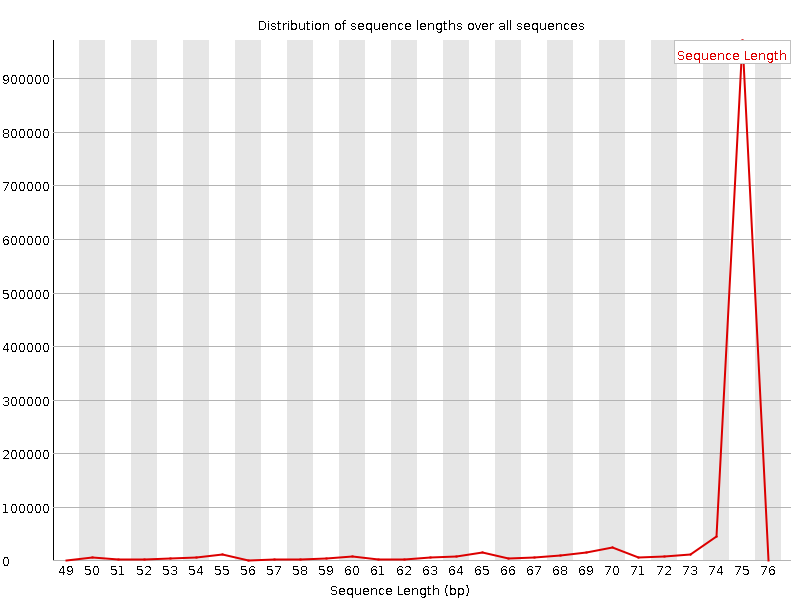
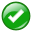
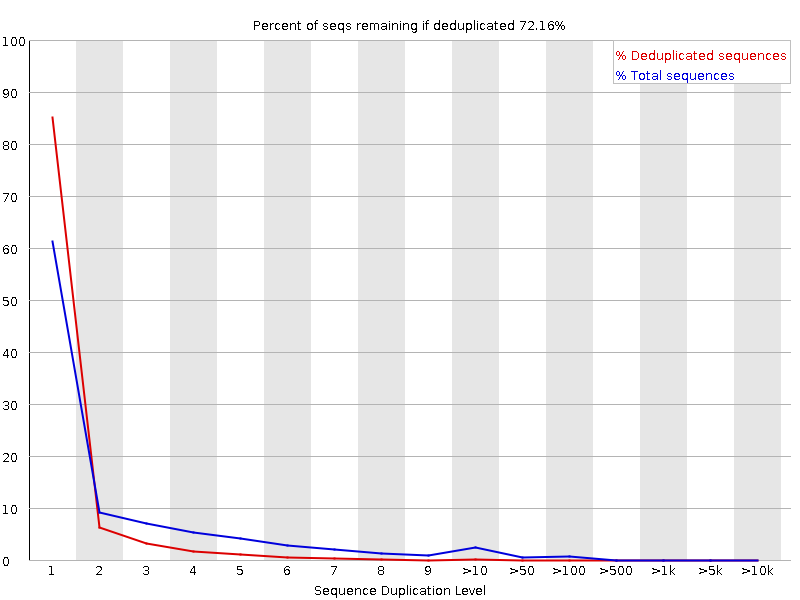
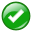
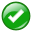
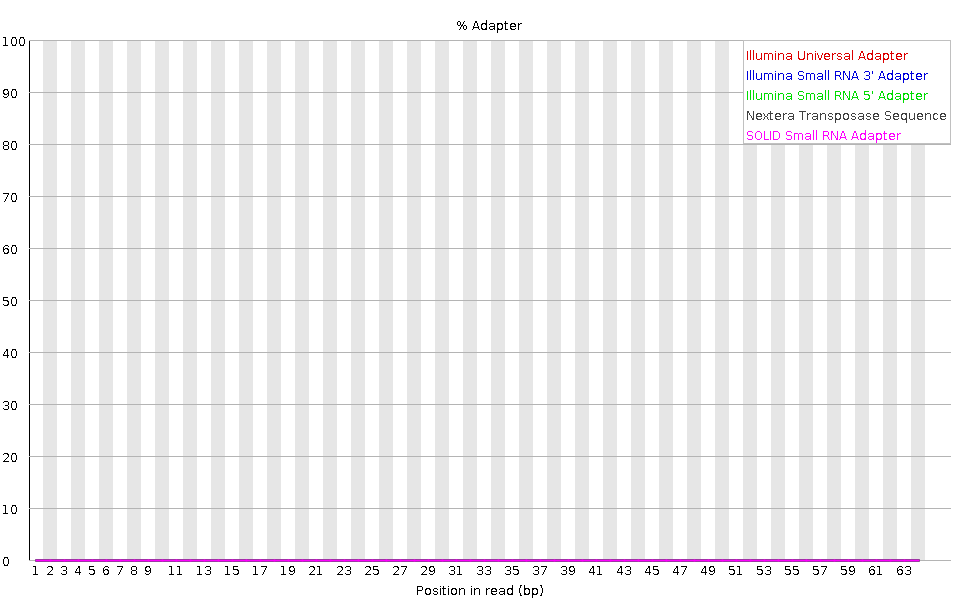

In [61]:
display_fastqc_report(dna_read_filename_prefix + '.1.forward.unpaired_fastqc.html')

Basic Statistics Measure Value Filename SRR10720402.2.reverse.paired.fastq.gz File type Conventional base calls Encoding Sanger / Illumina 1.9 Total Sequences 27172718 Sequences flagged as poor quality 0 Sequence length 50-75 %GC 43 Per base sequence quality Per tile sequence quality Per sequence quality scores Per base sequence content Per sequence GC content Per base N content Sequence Length Distribution Sequence Duplication Levels Overrepresented sequences No overrepresented sequences Adapter Content
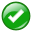
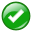
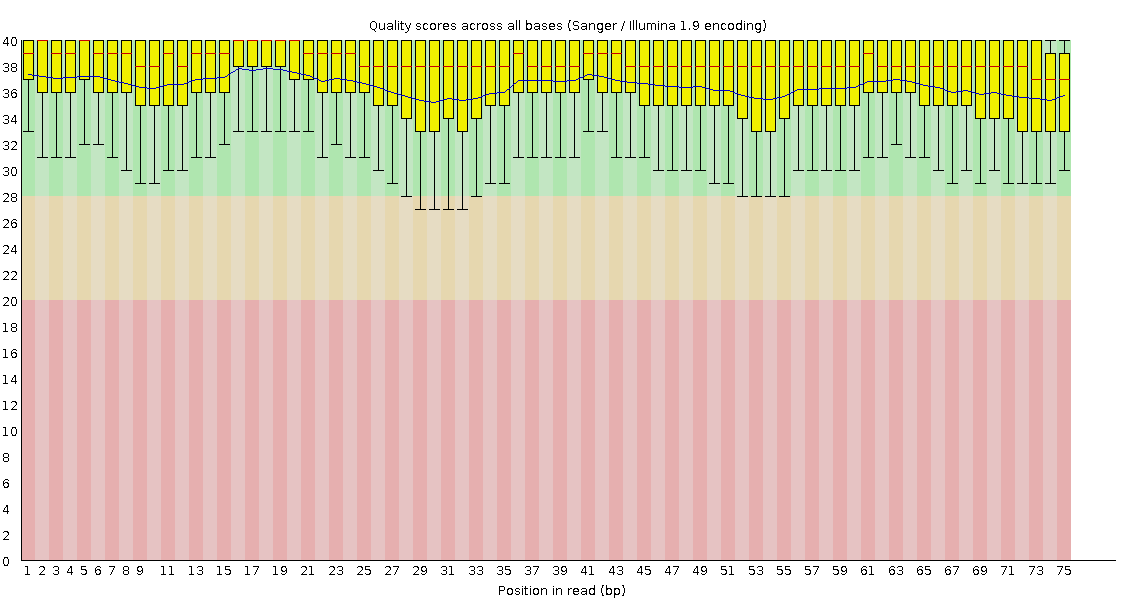
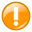
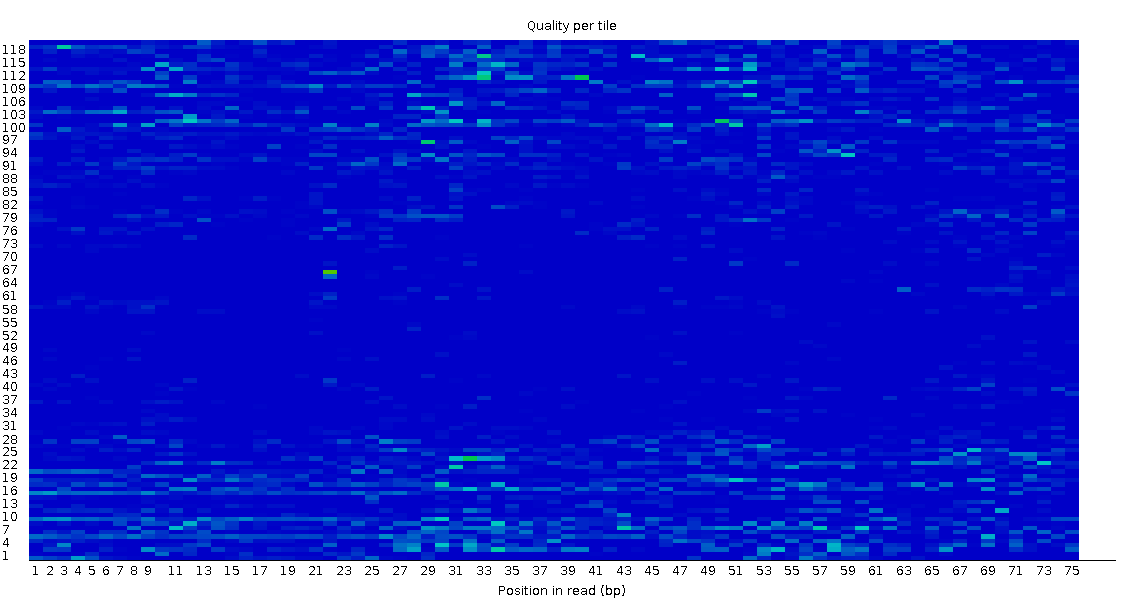
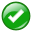
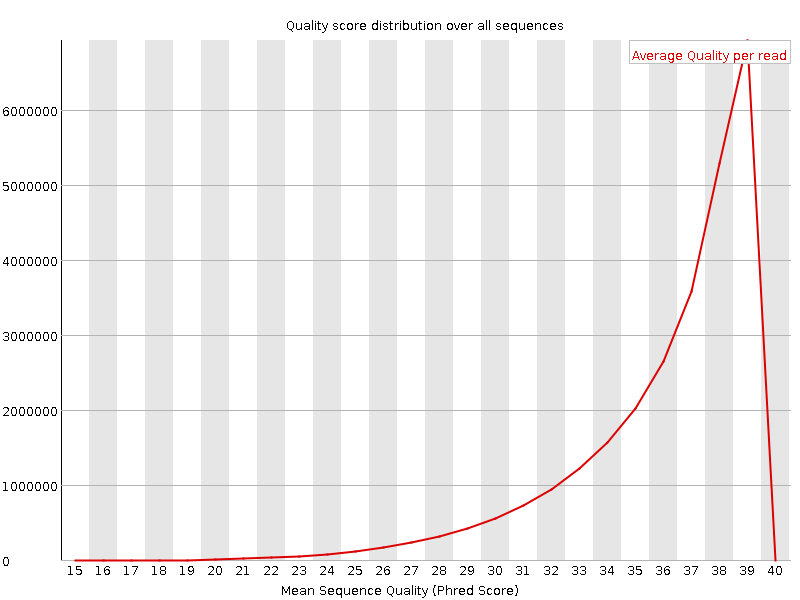
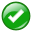
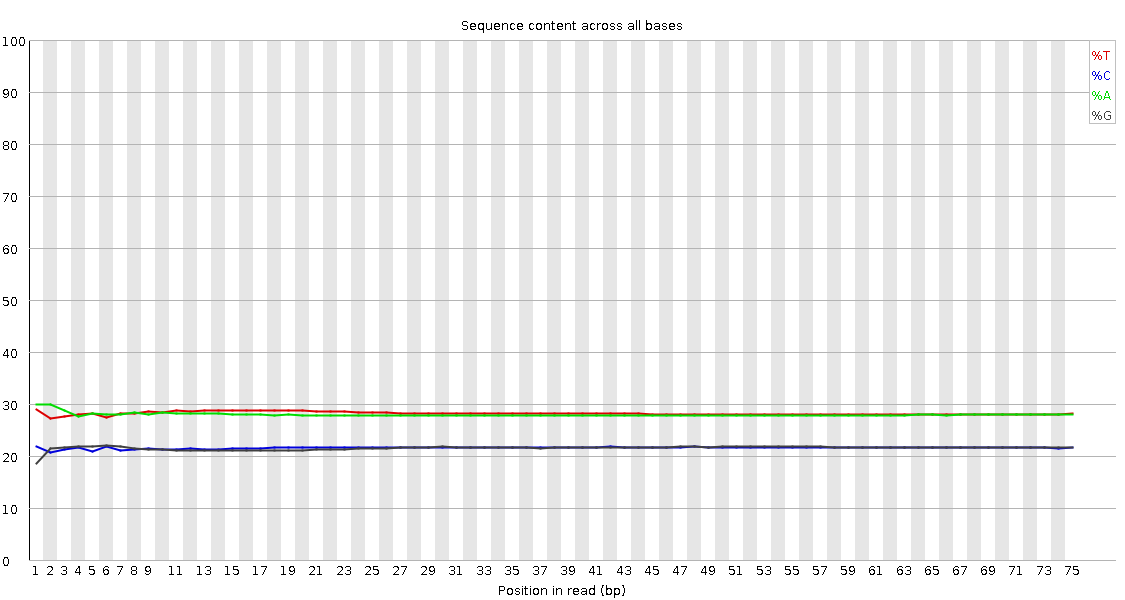
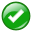
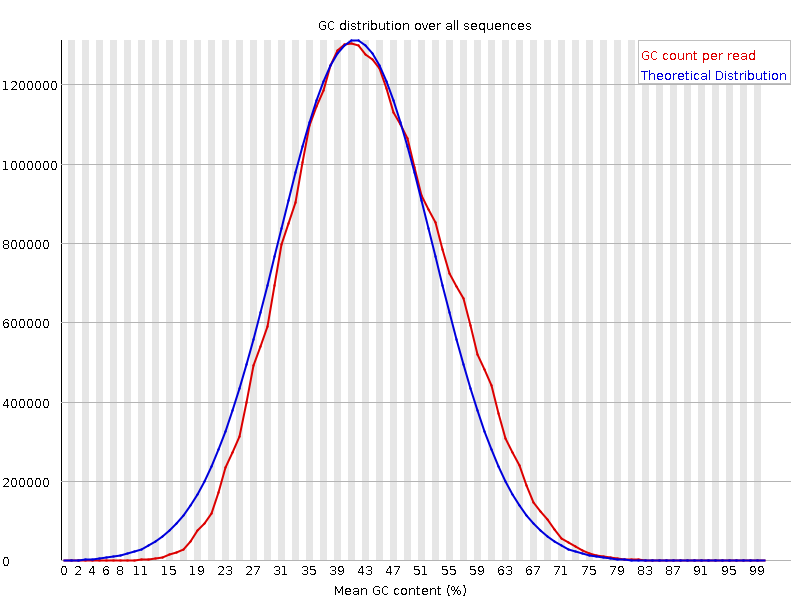
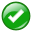
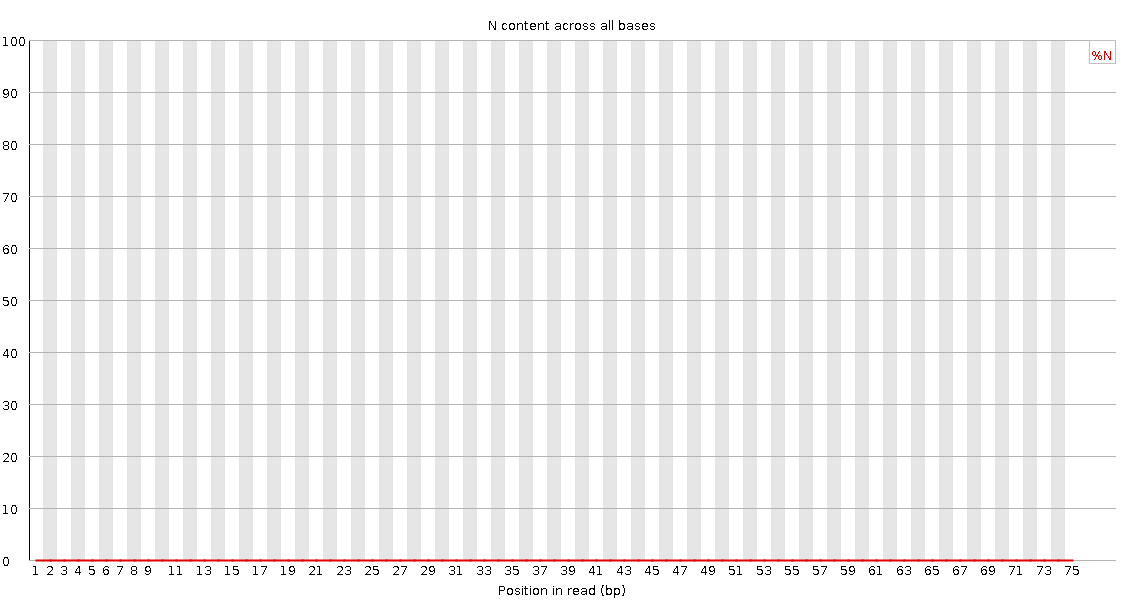
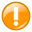
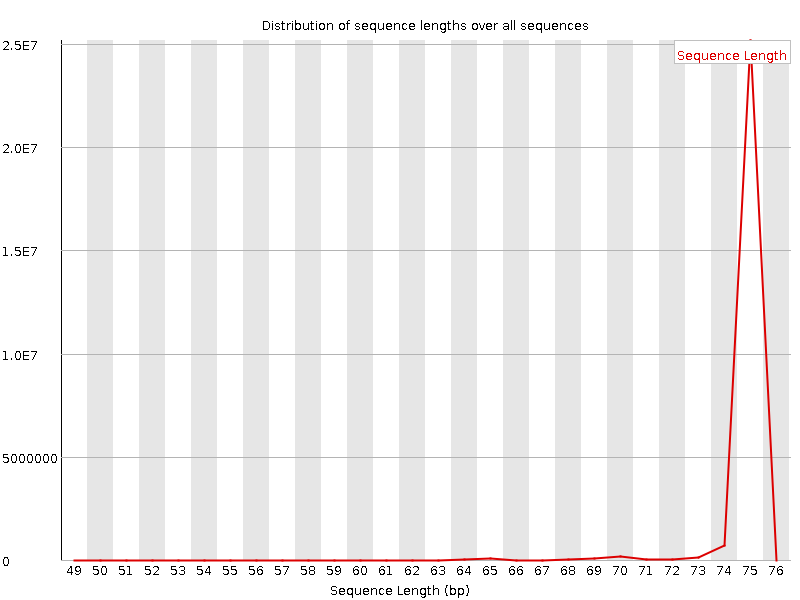
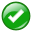
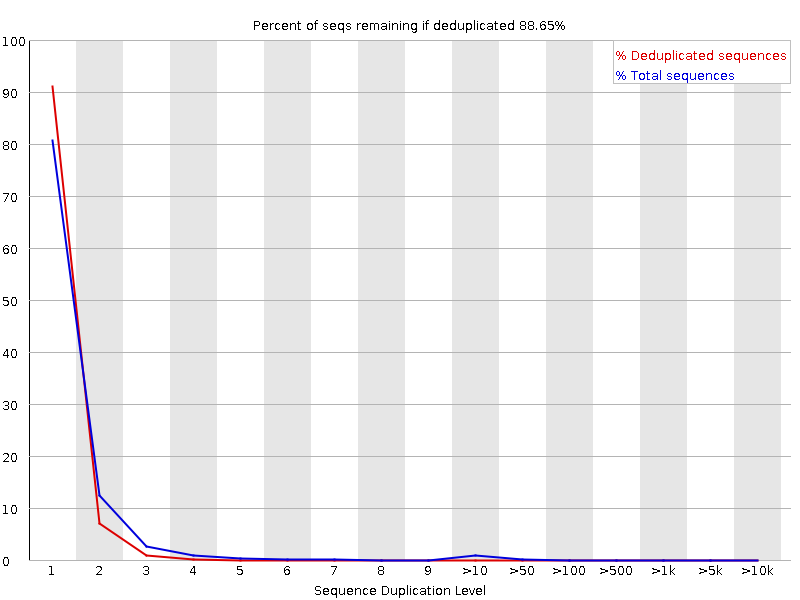
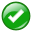
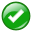
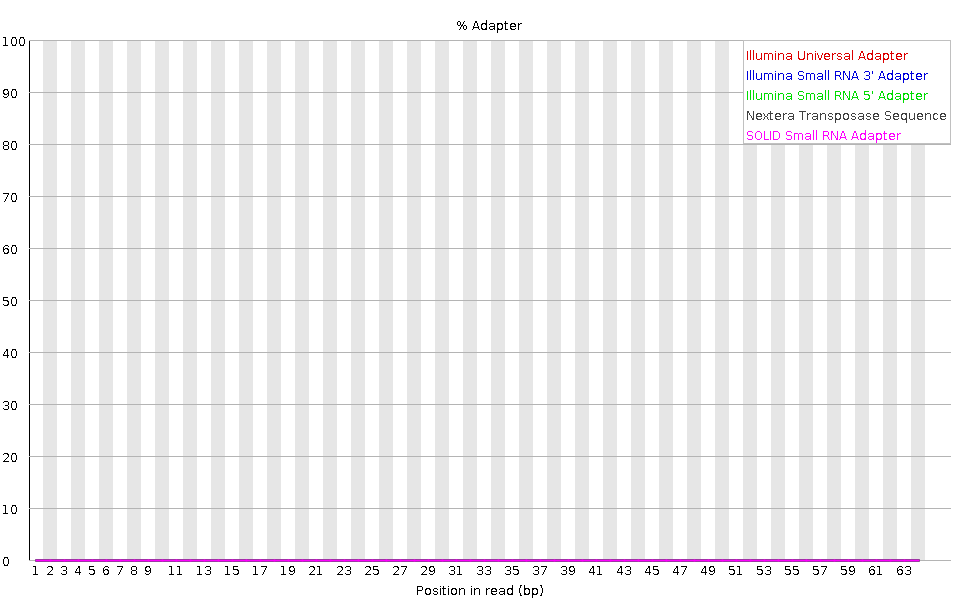

In [63]:
display_fastqc_report(dna_read_filename_prefix + '.2.reverse.paired_fastqc.html')

Basic Statistics Measure Value Filename SRR10720402.2.reverse.unpaired.fastq.gz File type Conventional base calls Encoding Sanger / Illumina 1.9 Total Sequences 473184 Sequences flagged as poor quality 0 Sequence length 50-75 %GC 49 Per base sequence quality Per tile sequence quality Per sequence quality scores Per base sequence content Per sequence GC content Per base N content Sequence Length Distribution Sequence Duplication Levels Overrepresented sequences No overrepresented sequences Adapter Content
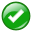
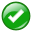
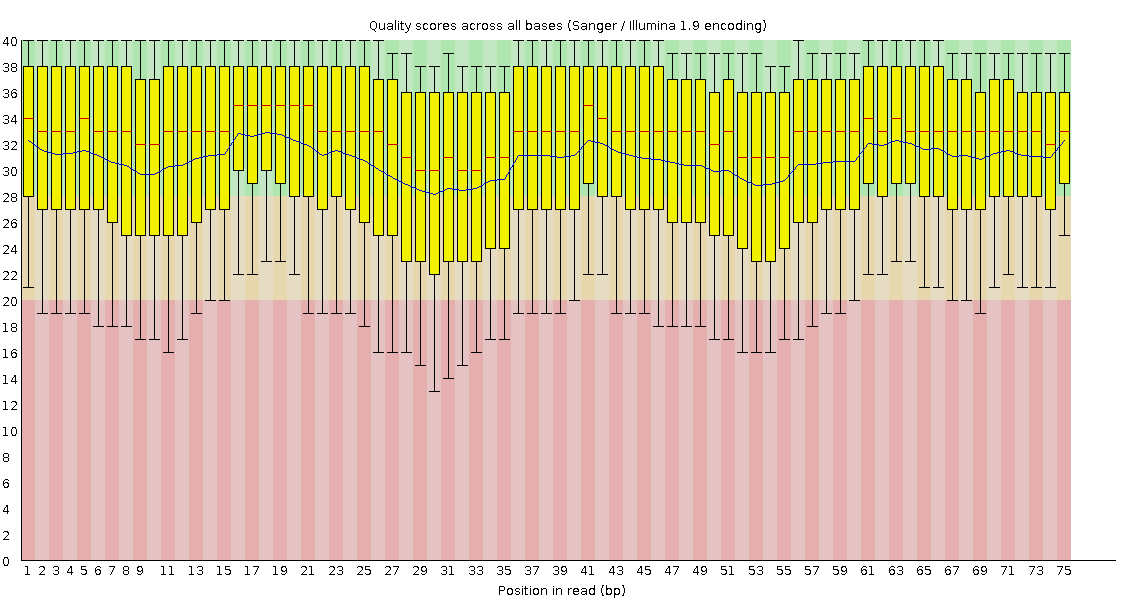
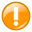
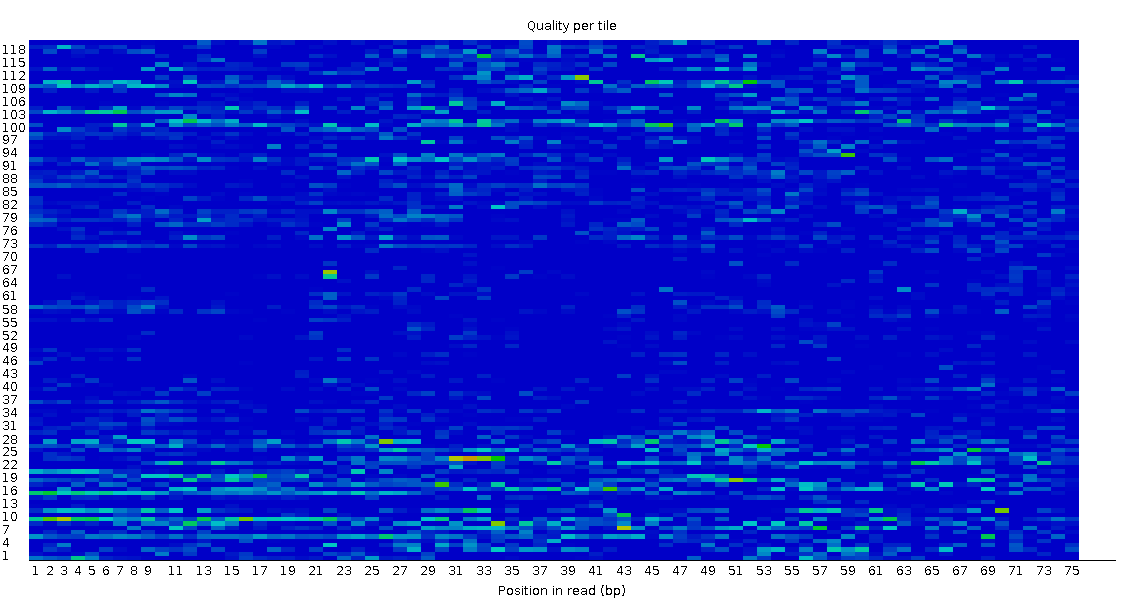
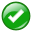
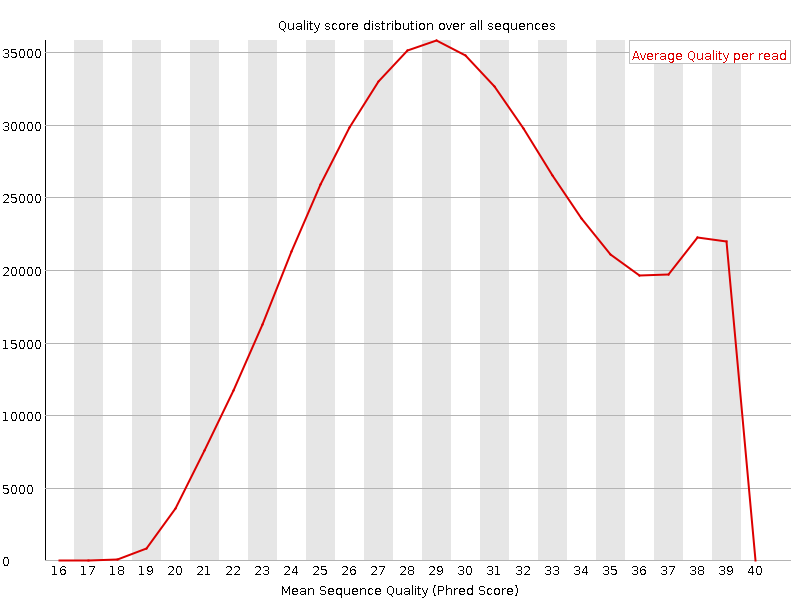
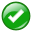
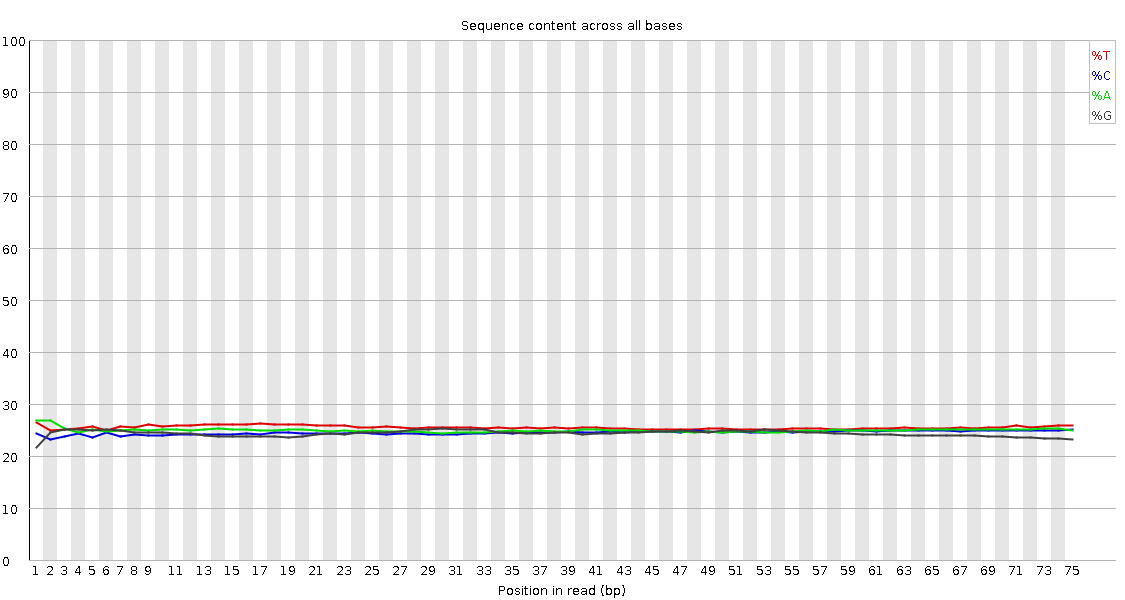
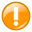
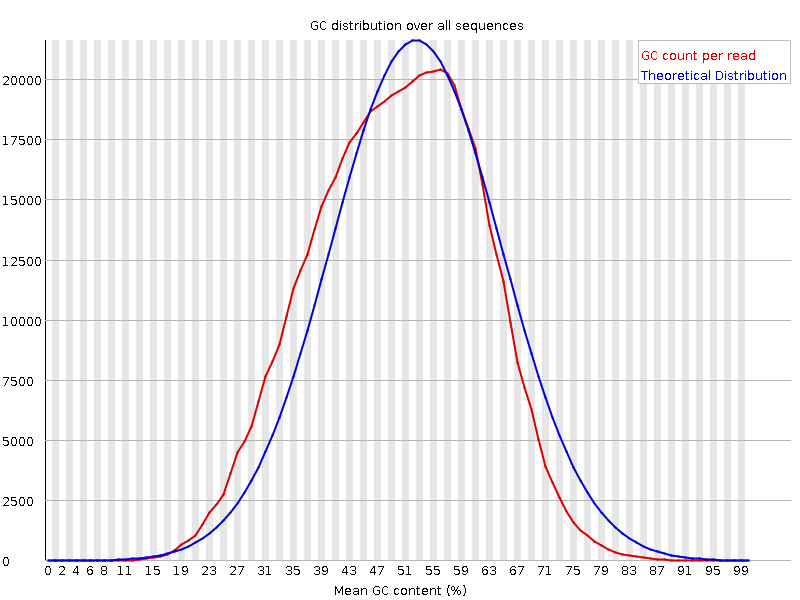
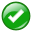
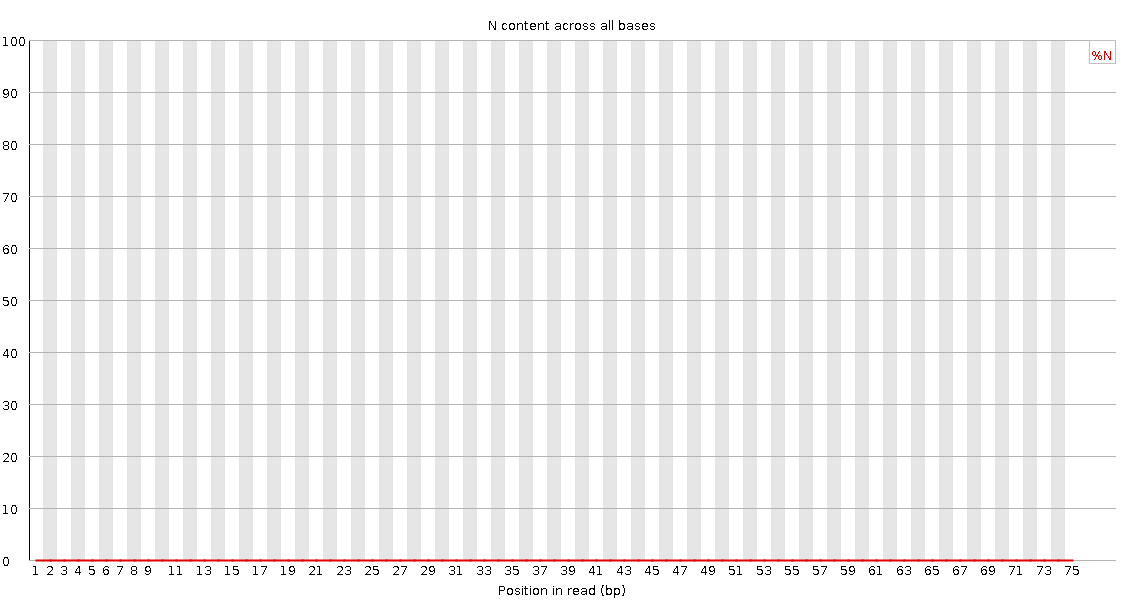
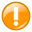
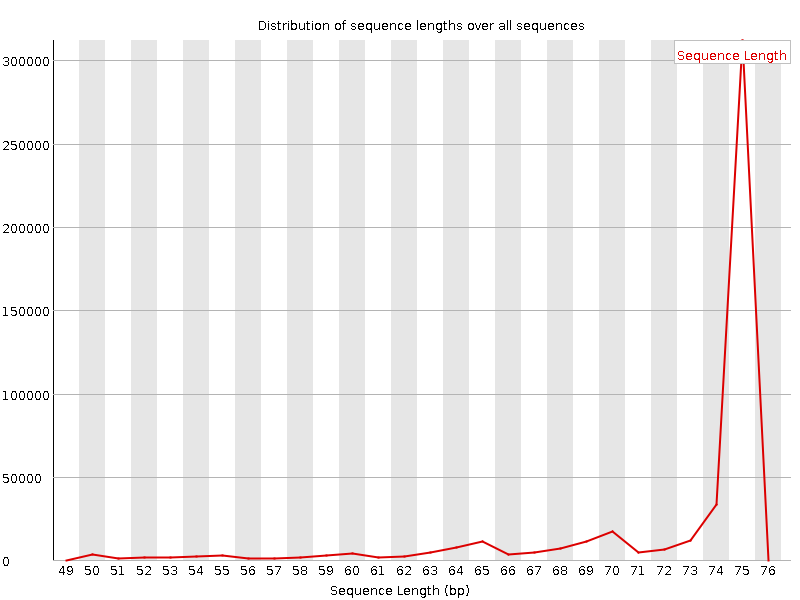
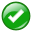
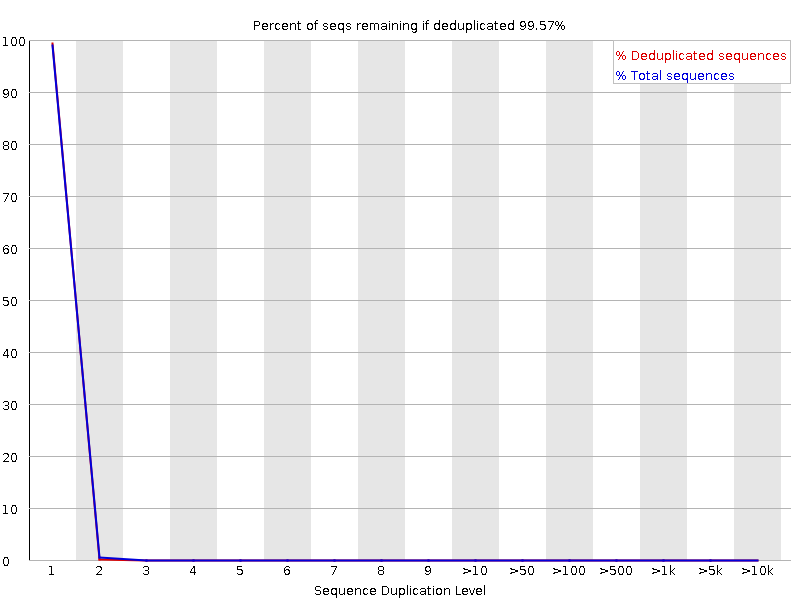
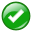
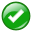
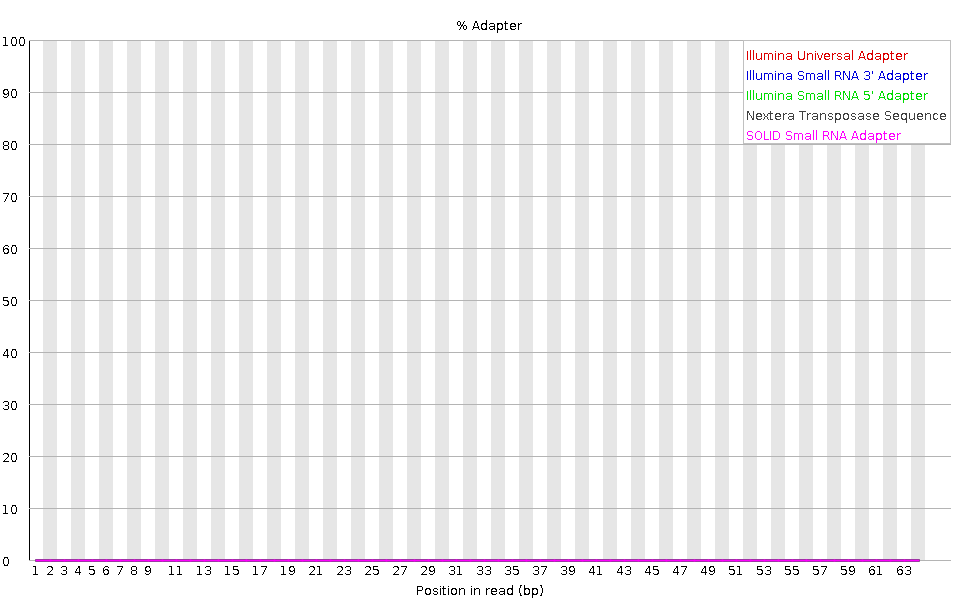

In [64]:
display_fastqc_report(dna_read_filename_prefix + '.2.reverse.unpaired_fastqc.html')

>Проанализируйте качество чтений

>какое количество пар(!) чтений осталось (paired) в штуках

>какой процент пар(!) чтений остался (paired) (процент от исходного количества пар чтений)

>краткий комментарий о сравнении качества чтений после(!!) триммирования: paired vs unpaired

>краткий комментарий о сравнении качества чтений до и после триммирования (только paired).

>как изменилась длина чтений после триммирования?

1. `27172718`
2. 93%
3. основная разница между paired и unpaired заключается в распределении средней phred последовательности - непарные чтения гораздо чаще имеют плохую оценку, средняя оценка по позициям так же ниже парных. помимо этого, состав GC у непарных сильнее отклоняется от нормального
4. после триммирования стало больше чтений с более плохой средней по последовательностям, но средняя по позициям стала выросла. состав GC стал ближе к нормальному. в целом можно утверждать, что качество чтений выросло
5. для парных чтений, прошедших фильтрацию, стала варьироваться от 50 до 75 bp

## Сводный отчет о качестве чтений 

`multiqc` генерирует html отчет. так же она умеет отдельно экспортировать статичные графики из отчета. воспользуемся этим, чтобы вставить графики в наш отчет.
сгенерим отчет во временную папку, а потом перенесем его в постоянную папку (см. SELinux context)

In [29]:
import random
import multiqc


mqc_tmp_dir = f"{dna_read_filename_prefix}.multiqc.d.{random.randint(1, 100)}"
mqc_dir = mqc_tmp_dir[:mqc_tmp_dir.rfind('.')]

multiqc.utils.config.export_plot_formats = ['svg']

In [164]:
#multiqc.utils.config.custom_plot_config = {
#    'id': 'fastqc_per_sequence_gc_content_plot',
#    'co
#}
multiqc.multiqc.run(
    analysis_dir=dna_reads_dir,
    force=True,
    filename=f"{os.environ['READ_ID']}.multiqc.html",
    outdir=mqc_tmp_dir,
    make_data_dir=True,
    no_megaqc_upload=True,
    no_ansi=True,
    export_plots=True,
)

/// MultiQC 🔍 | v1.15

|           multiqc | MultiQC Version v1.25.1 now available!
|           multiqc | Search path : /mnt/scratch/NGS/gind.alex/dna_reads


|            fastqc | Found 6 reports
|           multiqc | Report      : ../../../../mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402.multiqc.d.51/SRR10720402.multiqc.html
|           multiqc | Data        : ../../../../mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402.multiqc.d.51/SRR10720402.multiqc_data
|           multiqc | Plots       : ../../../../mnt/scratch/NGS/gind.alex/dna_reads/SRR10720402.multiqc.d.51/SRR10720402.multiqc_plots
|           multiqc | MultiQC complete


{'report': <module 'multiqc.utils.report' from '/opt/share/conda/lib/python3.9/site-packages/multiqc/utils/report.py'>,
 'config': <module 'multiqc.utils.config' from '/opt/share/conda/lib/python3.9/site-packages/multiqc/utils/config.py'>,
 'sys_exit_code': 0}

In [165]:
!!mv $mqc_tmp_dir $mqc_dir

[]

после генерации встроим графики в отчет

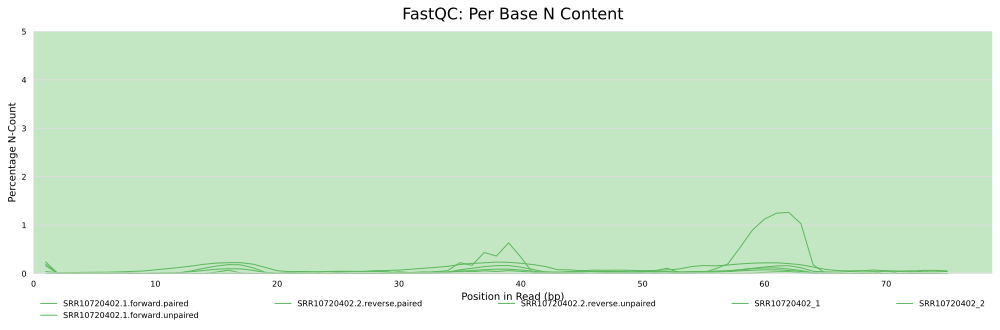

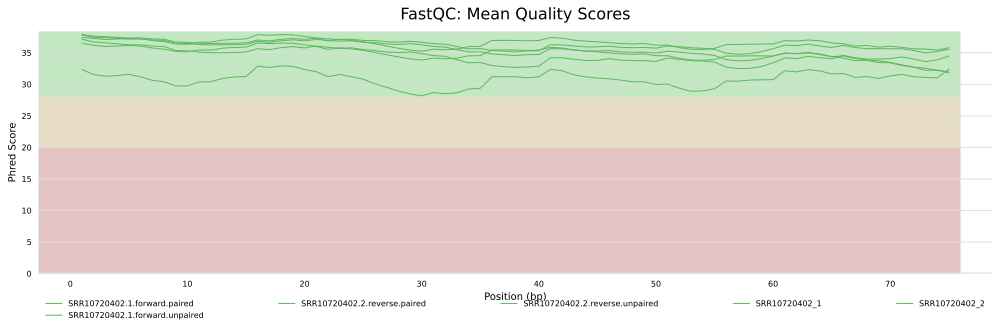

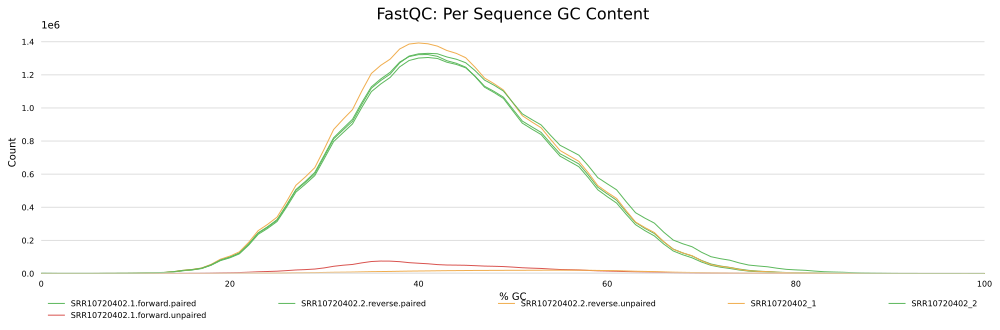

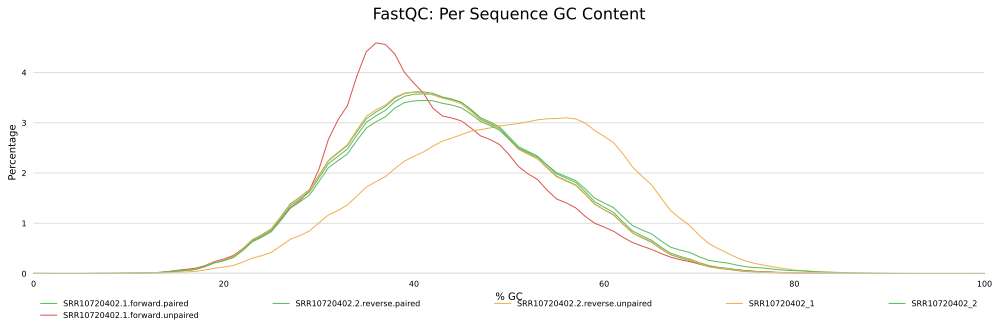

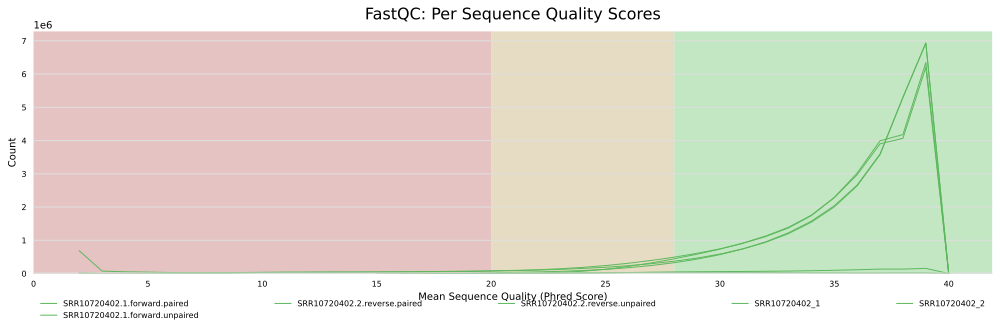

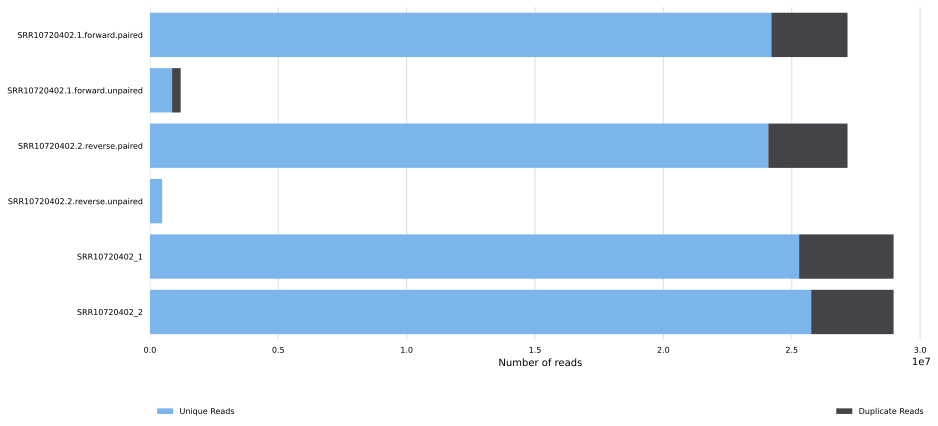

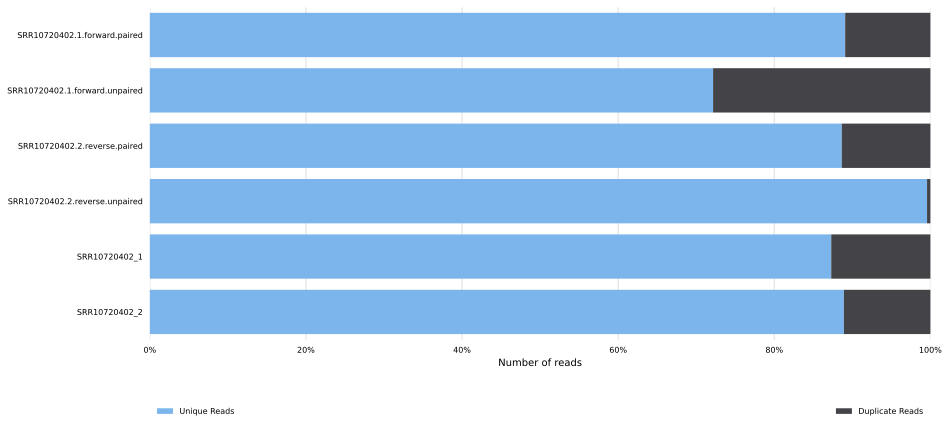

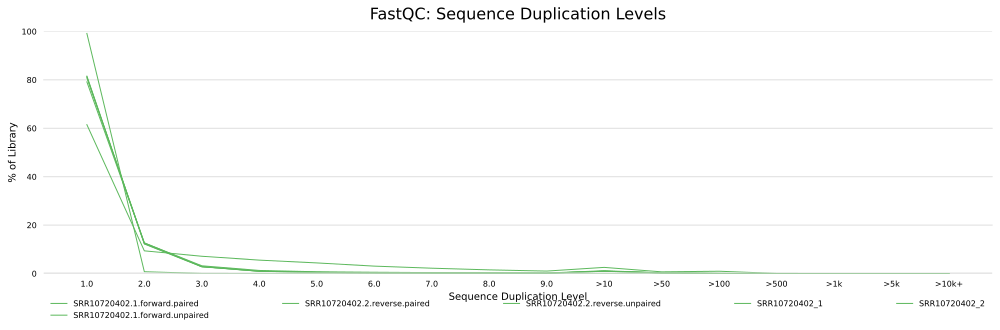

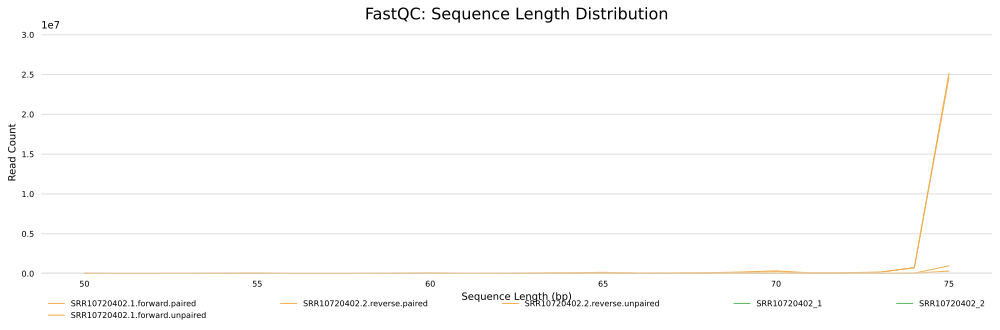

In [7]:
mqc_svg_dir = f"{mqc_dir}/{os.environ['READ_ID']}.multiqc_plots/svg"
for fn in sorted(os.listdir(mqc_svg_dir)):
    display.display_svg(display.SVG(filename=f"{mqc_svg_dir}/{fn}"))

# Картирование чтений на референсный геном

## Картирование

запустим `hisat2`. для использования построенных ранее индексов `*.ht2` передадим через параметр `-x` префикс пути до файлов индексов.
через `-p 25` укажем использовать 25 потоков.
параметр `--mm` используем для оптимизации (более быстрый доступ к файлам индекса).
укажем `--time` для того, чтобы вывести в лог статистику по времени выполнения.
используем `--no-spliced-alignment` для запрещения сплайсинга.
через `--met-file` укажем путь до файла, куда запишем метрики выполнения (для анализа, если будет необходимо).
параметр `--summary-file` указывает путь до файла, куда программа запишет отчет по выполнению.
используем `-1` для указания пути до прямых чтений и `-2` для обратных, а так же `--fr` для указания, что
параметром `-1` задавались прямые чтения и `-2` для обратные.
через `-S` укажем путь до вывода sam файла.

In [176]:
%%bash
hisat2 \
    --fr \
    --mm \
    -p 25 \
    --time \
    --no-spliced-alignment \
    --met-file "$NGS_DIR/$NICKNAME/hisat/metrics.txt" \
    --summary-file "$NGS_DIR/$NICKNAME/hisat/summary.txt" \
    -x "$NGS_DIR/$NICKNAME/hisat/index" \
    -1 "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.1.forward.paired.fastq.gz" \
    -2 "$NGS_DIR/$NICKNAME/dna_reads/${READ_ID}.2.reverse.paired.fastq.gz" \
    -S "$NGS_DIR/$NICKNAME/hisat/out.sam"

Time loading forward index: 00:00:00
Time loading reference: 00:00:00
Multiseed full-index search: 00:17:50
27172718 reads; of these:
  27172718 (100.00%) were paired; of these:
    25750491 (94.77%) aligned concordantly 0 times
    1332243 (4.90%) aligned concordantly exactly 1 time
    89984 (0.33%) aligned concordantly >1 times
    ----
    25750491 pairs aligned concordantly 0 times; of these:
      6907 (0.03%) aligned discordantly 1 time
    ----
    25743584 pairs aligned 0 times concordantly or discordantly; of these:
      51487168 mates make up the pairs; of these:
        51095280 (99.24%) aligned 0 times
        301822 (0.59%) aligned exactly 1 time
        90066 (0.17%) aligned >1 times
5.98% overall alignment rate
Time searching: 00:17:50
Overall time: 00:17:50


## Конвертация sam в bam

используем утилиту `samtools sort` для конвертации и сортировки исходного sam файла, указанного последним аргументом, в bam файл,
путь до которого указывается через `-o`. установим 5 потоков для выполнения через `--threads`

In [4]:
!!samtools sort --threads 5 -o "$NGS_DIR/$NICKNAME/hisat/out.bam" "$NGS_DIR/$NICKNAME/hisat/out.sam"

['[bam_sort_core] merging from 15 files and 5 in-memory blocks...']

>Сколько весит sam файл в Гб?

>сколько весит bam файл в Гб?

In [10]:
!!ls -sh "$NGS_DIR/$NICKNAME/hisat/out.sam" "$NGS_DIR/$NICKNAME/hisat/out.bam"

['3.3G /mnt/scratch/NGS/gind.alex/hisat/out.bam',
 ' 11G /mnt/scratch/NGS/gind.alex/hisat/out.sam']

>удалите(!) sam, больше он не пригодится

In [11]:
!!rm "$NGS_DIR/$NICKNAME/hisat/out.sam"

[]

>Проиндексируйте получившийся bam файл, используя samtools index

через `-@` установим 5 потоков выполнения, а через `-o` укажем путь до результирующего файла с индексом bai

In [43]:
!!samtools index -@ 5 "$NGS_DIR/$NICKNAME/hisat/out.bam" -o "$NGS_DIR/$NICKNAME/hisat/out.bai"

[]

## Анализ bam файла

>Проанализируйте bam файл с помощью возможностей программы samtools `samtools flagstat file.bam`, результат запишите в текстовый файл. Изучите полученный файл

flagstat умеет выводить в формате tsv. этим можно воспользоваться, чтобы находу заменить его на md и встроить в отчет. для этого нужно вставить загаловок таблицы с описанием полей

In [8]:
def display_flagstat_tsv(content):
    flagstat = [list(reversed(line.split('\t'))) for line in content]
    flagstat[0][0] = 'total'
    flagstat.insert(0, [':---:']*3)
    flagstat.insert(0, ['param', 'QC-failed reads', 'QC-passed reads'])
    display.display_markdown('\n'.join([f"| {' | '.join(line)} |" for line in flagstat]), raw=True)

укажем формат вывода tsv через `-O`, используемые потоки через `-@`.
запишем получившийся отчет в файл, а так же получим его в stdout для преобразования в md с помощью утилиты `tee`,
которая свой stdin перенаправляет в указанный файл, а так же в stdout

In [68]:
flagstat = !samtools flagstat -@ 5 -O tsv "$NGS_DIR/$NICKNAME/hisat/out.bam" | tee "$NGS_DIR/$NICKNAME/hisat/flagstat.txt"
display_flagstat_tsv(flagstat)

| param | QC-failed reads | QC-passed reads |
| :---: | :---: | :---: |
| total | 0 | 54974931 |
| primary | 0 | 54345436 |
| secondary | 0 | 629495 |
| supplementary | 0 | 0 |
| duplicates | 0 | 0 |
| primary duplicates | 0 | 0 |
| mapped | 0 | 3879651 |
| mapped % | N/A | 7.06% |
| primary mapped | 0 | 3250156 |
| primary mapped % | N/A | 5.98% |
| paired in sequencing | 0 | 54345436 |
| read1 | 0 | 27172718 |
| read2 | 0 | 27172718 |
| properly paired | 0 | 2844454 |
| properly paired % | N/A | 5.23% |
| with itself and mate mapped | 0 | 2907478 |
| singletons | 0 | 342678 |
| singletons % | N/A | 0.63% |
| with mate mapped to a different chr | 0 | 0 |
| with mate mapped to a different chr (mapQ>=5) | 0 | 0 |

в отчете два столбца - статистика по чтениям, не проходящим по качеству, и по проходящим.

Из полученного после работы samtools flagstat файла узнайте:
1. Сколько чтений картировано на референс в штуках?

3879651

2. Сколько чтений картировано на референс в % от количества триммированных чтений?

7.06%

3. Сколько чтений картировано на референс в корректных парах в штуках?

2844454

4. Сколько чтений картировано на референс в корректных парах в % от количества триммированных чтений?

5.23%

## Получение чтений, картированных на вашу хромосому

>Получим чтения, картированные только на вашу хромосому. Используйте команду samtools view

используем `--bam` для указания выходного формата. вторым аргументом дадим путь до файла, полученного ранее из `samtools sort`.
третьим аргументом укажем название хромосомы, которое было записано в переменную на этапе работы с `faidx`.
перенаправим вывод в файл.

In [ ]:
!!samtools view --bam "$NGS_DIR/$NICKNAME/hisat/out.bam" "$CHR_NAME" > "$NGS_DIR/$NICKNAME/chr$CHR_ID.bam"

## Получение только правильно картированных пар чтений
 
добавим параметр `--require-flags` со значением `PROPER_PAIR`, чтобы получить только правильно картированные чтения.
это другая форма записи, требовавшаяся в задании `-f 0x2`
>Что указано в качестве значений для параметра -f?

согласно [мануалу](https://www.htslib.org/doc/samtools-flags.html) флаги можно указывать через запятую, используя имена флагов, или через битовую маску из флагов.
`0x2` - значение флага с имененем `PROPER_PAIR`, который фильтрует чтения, картированные правильно.

In [70]:
!!samtools view --bam --require-flags PROPER_PAIR "$NGS_DIR/$NICKNAME/chr$CHR_ID.bam" > "$NGS_DIR/$NICKNAME/chr$CHR_ID.proper.bam"

[]

>К полученному bam файлу, содержащему только правильно картированные на вашу хромосому пары чтений, примените уже знакомую команду samtools flagstat, сохранив выход в отдельный файл.

сделаем по аналогии с прошлым разом

In [71]:
flagstat = !samtools flagstat -@ 5 -O tsv "$NGS_DIR/$NICKNAME/chr$CHR_ID.proper.bam" | tee "$NGS_DIR/$NICKNAME/chr$CHR_ID.proper.flagstat.txt"
display_flagstat_tsv(flagstat)

| param | QC-failed reads | QC-passed reads |
| :---: | :---: | :---: |
| total | 0 | 3253816 |
| primary | 0 | 2844454 |
| secondary | 0 | 409362 |
| supplementary | 0 | 0 |
| duplicates | 0 | 0 |
| primary duplicates | 0 | 0 |
| mapped | 0 | 3253816 |
| mapped % | N/A | 100.00% |
| primary mapped | 0 | 2844454 |
| primary mapped % | N/A | 100.00% |
| paired in sequencing | 0 | 2844454 |
| read1 | 0 | 1422227 |
| read2 | 0 | 1422227 |
| properly paired | 0 | 2844454 |
| properly paired % | N/A | 100.00% |
| with itself and mate mapped | 0 | 2844454 |
| singletons | 0 | 0 |
| singletons % | N/A | 0.00% |
| with mate mapped to a different chr | 0 | 0 |
| with mate mapped to a different chr (mapQ>=5) | 0 | 0 |

## Изучите полученный файл (flagstat)

1. Сколько чтений картировано на референс в корректных парах в штуках?

2844454

2. Сколько чтений картировано на референс в корректных парах в % от общего количества картированных чтений?

87%

>Проиндексируйте полученный bam файл, содержащий только правильно спаренные картированные чтения нужной вам хромосомы.

In [30]:
!!samtools index -@ 5 "$NGS_DIR/$NICKNAME/chr$CHR_ID.proper.bam" -o "$NGS_DIR/$NICKNAME/chr$CHR_ID.proper.bai"

[]

# Получение вариантов

## Calling

>Что получается в первой части команды `bcftools mpileup`?

`bcftools mpileup` по нашим референсу, переданному через `-f`, и выравниванию, переданному последним аргументом,
строит таблицу на каждую прочитанную позицию в геноме с информацией о прочтении (глубина, качество, тд).
после чего `bcftools call` обогощает каждую позицию в таблице информацией о вариантах
и записывает результриующую таблицу в файл, указанный через `-o`.
флаг `-m` нужен для указания поиска нескольких аллелей. флаг `-v` нужен для того,
чтобы отфильтровать те строки таблиции (позиции) по которым вариантов не нашлось.

In [3]:
!!bcftools mpileup -f "$NGS_DIR/$NICKNAME/hg38/chr38.$CHR_ID.fa" "$NGS_DIR/$NICKNAME/chr$CHR_ID.proper.bam" | bcftools call -mv -o "$NGS_DIR/$NICKNAME/chr$CHR_ID.vcf"

['Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid',
 '[mpileup] 1 samples in 1 input files',
 '[mpileup] maximum number of reads per input file set to -d 250']

>Проанализируйте vcf файл с помощью программы bcftools stats. Запишите выходную информацию в файл.
Сколько получилось вариантов?
Сколько из полученных вариантов являются однонуклеотидными заменами?
Сколько получилось коротких вставок и делеций?

в файле статистики есть строки summary tsv таблицы. их первый столбец =SN. грепнем нужную статистику и возьмем значение параметром через cut.

In [11]:
!!bcftools stats "$NGS_DIR/$NICKNAME/chr$CHR_ID.vcf" > "$NGS_DIR/$NICKNAME/chr$CHR_ID.vchk"

[]

In [41]:
vcf_records = !grep -e '^SN.*number of records' "$NGS_DIR/$NICKNAME/chr$CHR_ID.vchk" | cut -f 4
vcf_snps = !grep -e '^SN.*number of SNPs' "$NGS_DIR/$NICKNAME/chr$CHR_ID.vchk" | cut -f 4
vcf_indels = !grep -e '^SN.*number of indels' "$NGS_DIR/$NICKNAME/chr$CHR_ID.vchk" | cut -f 4
# в переменных хранятся массивы строк stdout. переведем в числа
vcf_records, vcf_snps, vcf_indels = int(vcf_records[0]), int(vcf_snps[0]), int(vcf_indels[0])
print(vcf_records, vcf_snps, vcf_indels)

67674 66839 835


## Фильтрация вариантов

>К полученному vcf файлу примените...

In [13]:
!!bcftools filter -i'QUAL>30 && DP>50' "$NGS_DIR/$NICKNAME/chr$CHR_ID.vcf" > "$NGS_DIR/$NICKNAME/chr$CHR_ID.filtered.vcf"

[]

>К фильтрованному vcf файлу примените уже знакомую команду bcftools stats

In [31]:
!!bcftools stats "$NGS_DIR/$NICKNAME/chr$CHR_ID.filtered.vcf" > "$NGS_DIR/$NICKNAME/chr$CHR_ID.filtered.vchk"

[]

>Сколько осталось вариантов после фильтрации (в штуках и в процентах)?
Сколько осталось однонуклеотидных замен (в штуках и в процентах)? 
Сколько осталось коротких вставок и делеций (в штуках и в процентах)?

In [44]:
vcf_filtered_records = !grep -e '^SN.*number of records' "$NGS_DIR/$NICKNAME/chr$CHR_ID.filtered.vchk" | cut -f 4
vcf_filtered_snps = !grep -e '^SN.*number of SNPs' "$NGS_DIR/$NICKNAME/chr$CHR_ID.filtered.vchk" | cut -f 4
vcf_filtered_indels = !grep -e '^SN.*number of indels' "$NGS_DIR/$NICKNAME/chr$CHR_ID.filtered.vchk" | cut -f 4
# в переменных хранятся массивы строк stdout. переведем в числа
vcf_filtered_records, vcf_filtered_snps, vcf_filtered_indels = int(vcf_filtered_records[0]), int(vcf_filtered_snps[0]), int(vcf_filtered_indels[0])
print(vcf_filtered_records, vcf_filtered_snps, vcf_filtered_indels)

def percentage(part, whole):
    p = 100 * float(part)/float(whole)
    return f"{p:.2f}%"

print(percentage(vcf_filtered_records, vcf_records), percentage(vcf_filtered_snps, vcf_snps), percentage(vcf_filtered_indels, vcf_indels))

1269 1220 49
1.88% 1.83% 5.87%


## Аннотация вариантов

Category Count 
 Variants processed 1269 Variants filtered out 0 Novel / existing variants 359 (28.3) / 910 (71.7) Overlapped genes 570 Overlapped transcripts 3768 Overlapped regulatory features 12

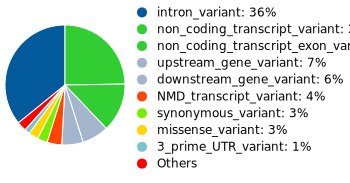

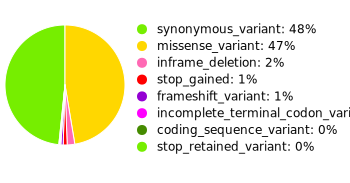

In [6]:
from IPython import display

display.display_html(display.HTML(filename='vep.stats.table.html'))
display.display_svg(display.SVG(filename='vep.stats.all_consequences.svg'))
display.display_svg(display.SVG(filename='vep.stats.coding_consequences.svg'))

>Сколько получилось вариантов с IMPACT HIGH?

0